In [73]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import ast
from analyze_masks import analyze_masks_and_list_exceptions

def categorize_data(data, column):
    """ Categorize the data based on quantiles for a specific column """
    q33 = data[column].quantile(0.33)
    q66 = data[column].quantile(0.66)
    
    category_labels = ["small", "medium", "large"]
    
    conditions = [
        (data[column] <= q33),
        (data[column] > q33) & (data[column] <= q66),
        (data[column] > q66)
    ]
    
    data[f'{column}_category'] = np.select(conditions, category_labels)
    return data

In [74]:
def load_and_process_data(file_path, base_dir, masks_dir, class_to_grayscale_map):
    data = pd.read_csv(file_path)
    confidence_columns = [col for col in data.columns if 'confidence' in col]
    for column in confidence_columns:
        data[column] = data[column].apply(ast.literal_eval)

    data['width'] = 0
    data['height'] = 0
    data['object_percentage'] = 0.0


    for index, row in data.iterrows():
        class_id = row['id'].split('_')[0]
        picture_name = row['picture_name']
        picture_base_name = os.path.splitext(picture_name)[0]

        img_path = os.path.join(base_dir, 'train', class_id, picture_name)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                data.at[index, 'width'] = width
                data.at[index, 'height'] = height
        except FileNotFoundError:
            print(f"Image not found: {img_path}")

        mask_name = picture_base_name + '.png'
        mask_path = os.path.join(masks_dir, class_id, mask_name)
        try:
            with Image.open(mask_path) as mask:
                mask_array = np.array(mask)
                if class_id in class_to_grayscale_map:
                    relevant_value = class_to_grayscale_map[class_id]
                    print(f"Processing mask for index {index}, class_id {class_id}, relevant_value {relevant_value}")
                    object_pixels = np.sum(mask_array == relevant_value)
                    total_pixels = width * height
                    if total_pixels > 0:
                        data.at[index, 'object_percentage'] = (object_pixels / total_pixels) * 100
                    print(f"object_pixels: {object_pixels}, total_pixels: {total_pixels}, object_percentage: {data.at[index, 'object_percentage']}")
        except FileNotFoundError:
            print(f"Mask not found for image: {mask_path}")

    # Check object_percentage values before categorization
    print(data[['object_percentage']].describe())

    data = categorize_data(data, 'object_percentage')

    return data

In [75]:
def parse_synset_mapping(filepath):
    with open(filepath, 'r') as file:
        class_dict = {}
        for row_number, line in enumerate(file, start=1):
            class_id, description = line.strip().split(' ', 1)
            class_dict[class_id] = {
                "description": description,
                "value": row_number - 1
            }
    return class_dict

In [76]:
class_to_grayscale_map, _ = analyze_masks_and_list_exceptions('../data/masks')

Class: n02412080, Most Common Nonzero Grayscale Value (by presence): 17, Presence Count: 1129
    Images without the most common grayscale value (17): ['n02412080_13145.png', 'n02412080_1976.png', 'n02412080_6399.png', 'n02412080_7812.png', 'n02412080_16811.png', 'n02412080_8153.png', 'n02412080_2188.png', 'n02412080_19324.png', 'n02412080_18733.png', 'n02412080_2270.png', 'n02412080_16830.png', 'n02412080_16254.png', 'n02412080_13623.png', 'n02412080_26458.png', 'n02412080_3944.png', 'n02412080_1040.png', 'n02412080_10804.png', 'n02412080_13818.png', 'n02412080_11852.png', 'n02412080_791.png', 'n02412080_17063.png']
Class: n02107574, Most Common Nonzero Grayscale Value (by presence): 12, Presence Count: 1147
    Images without the most common grayscale value (12): ['n02107574_3660.png', 'n02107574_142.png', 'n02107574_690.png']
Class: n01833805, Most Common Nonzero Grayscale Value (by presence): 3, Presence Count: 1131
    Images without the most common grayscale value (3): ['n0183380

In [77]:
print(f"class_to_grayscale_map: {class_to_grayscale_map}")

class_to_grayscale_map: {'n02412080': 17, 'n02107574': 12, 'n01833805': 3, 'n02124075': 8, 'n02415577': 17, 'n02105641': 12, 'n02123394': 8, 'n01534433': 3, 'n02106662': 12, 'n01558993': 3}


In [78]:
base_dir = '../data'
masks_dir = '../data/masks'
file_path_resnet = '../image_confidence_scores_resnet.csv'
file_path_convnext = '../image_confidence_scores_convnext.csv'
synset_path = '../data/LOC_synset_mapping.txt'

data_resnet = load_and_process_data(file_path_resnet, base_dir, masks_dir, class_to_grayscale_map)
data_convnext = load_and_process_data(file_path_convnext, base_dir, masks_dir, class_to_grayscale_map)
class_dict = parse_synset_mapping(synset_path)

category_distribution_resnet = data_resnet['object_percentage_category'].value_counts()
print(category_distribution_resnet)
print(data_resnet.head())

Processing mask for index 0, class_id n02412080, relevant_value 17
object_pixels: 16834, total_pixels: 187500, object_percentage: 8.978133333333334
Processing mask for index 1, class_id n02412080, relevant_value 17
object_pixels: 58706, total_pixels: 187500, object_percentage: 31.309866666666668
Processing mask for index 2, class_id n02412080, relevant_value 17
object_pixels: 73604, total_pixels: 166500, object_percentage: 44.206606606606606
Processing mask for index 3, class_id n02412080, relevant_value 17
object_pixels: 94807, total_pixels: 177500, object_percentage: 53.41239436619718
Processing mask for index 4, class_id n02412080, relevant_value 17
object_pixels: 38742, total_pixels: 200000, object_percentage: 19.371
Processing mask for index 5, class_id n02412080, relevant_value 17
object_pixels: 23673, total_pixels: 187500, object_percentage: 12.6256
Processing mask for index 6, class_id n02412080, relevant_value 17
object_pixels: 81185, total_pixels: 166500, object_percentage: 4

In [79]:
import pickle

def save_df(df, path):
    with open(path, 'wb') as f:
        pickle.dump(df, f)

def load_df(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [80]:
!pwd

/home/paul/Coding/Studies/Magisterka/BackgroundImpactAnalysis/analysis


In [81]:
import os

resnet_results_path = os.path.join('results', 'resnet_df.pkl')
convnext_results_path = os.path.join('results', 'convnext_df.pkl')
save_df(data_resnet, resnet_results_path)
save_df(data_convnext, convnext_results_path)

In [82]:
def parse_synset_mapping(filepath):
    with open(filepath, 'r') as file:
        true_class_dic = {}
        description_dic = {}

        for row_number, line in enumerate(file, start=1):
            class_id, description = line.strip().split(' ', 1)
            true_class_dic[class_id] = str(row_number - 1)
            description_dic[class_id] = str(description)
    return true_class_dic, description_dic

In [83]:
synset_path = '../data/LOC_synset_mapping.txt'

true_class, description = parse_synset_mapping(synset_path)

In [84]:
def add_true_labels(df, true_class):
    true_labels = []
    desc_list = []
    for index, row in df.iterrows():
        class_id = row['id'].split('_')[0]
        true_label = true_class.get(class_id, 'Unknown')
        desc = description.get(class_id, 'Unknown')
        true_labels.append(true_label)
        desc_list.append(desc)
    df['true_label'] = true_labels
    df['true_label_description'] = desc_list
    return df

In [85]:
def process_results(df):
    confidence_columns = [col for col in df.columns if col.endswith('_confidence')]


    for column in df[confidence_columns]:
        predicted_labels = [next(iter(dict(x[0]))) for x in df[column]]
        scores = [next(iter(dict(x[0]).values())) for x in df[column]]
        prefix = column.split('_')[:-1][0]
        df[f'{prefix}_score'] = scores
        df[f'{prefix}_prediction'] = predicted_labels
    
    df.drop(columns=confidence_columns, inplace=True)

In [86]:
resnet_df = load_df(resnet_results_path)
convnext_df = load_df(convnext_results_path)

resnet_df = add_true_labels(resnet_df, true_class)
convnext_df = add_true_labels(convnext_df, true_class)

process_results(resnet_df)
process_results(convnext_df)

resnet_df = resnet_df.drop(columns=['width', 'height', 'object_percentage', 'picture_name', 'id'])
convnext_df = convnext_df.drop(columns=['width', 'height', 'object_percentage', 'picture_name', 'id'])

print(resnet_df.shape, convnext_df.shape)
pd.set_option('display.max_columns', None)


(10000, 27) (10000, 27)


In [87]:
resnet_df.head()

object_percentage_category true_label true_label_description  \
0                      small        348               ram, tup   
1                     medium        348               ram, tup   
2                      large        348               ram, tup   
3                      large        348               ram, tup   
4                     medium        348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       58.839279                  349     80.977097                348   
1       75.892090                  348     22.872158                348   
2       81.076469                  348     93.878342                348   
3       53.754341                  348     70.883713                349   
4       89.708168                  349     87.256088                349   

   low_score  low_prediction  city_score  city_prediction  sky_score  \
0  50.551521             349   69.934639              348  82.987450   
1  69.402061             348   88.528374              348  69.020668   
2  62.501762             348   58.977772              348  94.132629   
3  62.867821             349   50.269855              348  60.222435   
4  83.907135             349   83.456581              349  82.660828   

   sky_prediction  jungle_score  jungle_prediction   no_score  no_prediction  \
0             348     72.272240                348  29.558765            240   
1             348     65.185081                348  34.195347            295   
2             348     95.790382                348  56.970715            295   
3             349     52.651096                348  11.731533            649   
4             349     65.849808                349  91.065613            349   

   high_score  high_prediction  water_score  water_prediction  snow_score  \
0   87.865593              348    79.904648               348   67.014305   
1   86.046425              348    51.148842               348   80.982758   
2   87.129959              348    95.263901               348   75.683281   
3   58.879681              349    50.064980               349   70.590103   
4   77.554497              349    67.722954               349   88.169632   

   snow_prediction  indoor_score  indoor_prediction  mountain_score  \
0              349     26.773108                453       77.038040   
1              348     16.747709                 87       92.803429   
2              348     89.990028                348       93.176178   
3              349     59.058559                349       68.489357   
4              349     74.471443                349       88.701241   

   mountain_prediction  
0                  349  
1                  348  
2                  348  
3                  349  
4                  349

In [88]:
convnext_df.head()

object_percentage_category true_label true_label_description  \
0                      small        348               ram, tup   
1                     medium        348               ram, tup   
2                      large        348               ram, tup   
3                      large        348               ram, tup   
4                     medium        348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       46.373386                  349     39.178246                349   
1       78.177628                  348     78.905365                348   
2       79.154984                  348     75.236961                348   
3       40.402241                  348     41.739841                349   
4       49.981297                  349     44.770977                349   

   low_score  low_prediction  city_score  city_prediction  sky_score  \
0  35.915047             349   36.261684              349  32.841434   
1  81.804100             348   85.499680              348  77.875259   
2  77.332947             348   73.829636              348  77.585464   
3  37.637833             348   39.782448              349  36.871704   
4  32.670235             348   42.254787              349  34.506985   

   sky_prediction  jungle_score  jungle_prediction   no_score  no_prediction  \
0             348     34.654091                349  32.191479            348   
1             348     84.753433                348  30.929214            825   
2             348     79.860634                348  52.488834              8   
3             348     33.927750                348  30.554974            295   
4             349     33.637314                349  64.156876            349   

   high_score  high_prediction  water_score  water_prediction  snow_score  \
0   35.655186              349    33.616207               349   52.296246   
1   80.494812              348    81.612816               348   81.916199   
2   73.709946              348    76.116119               348   58.095898   
3   37.928951              348    39.006672               349   43.786774   
4   33.935677              349    35.364922               349   44.977673   

   snow_prediction  indoor_score  indoor_prediction  mountain_score  \
0              349     34.621975                349       49.499184   
1              348     81.708229                348       85.559204   
2              348     73.713272                348       64.670166   
3              349     41.510838                349       39.187191   
4              349     47.262661                349       44.087524   

   mountain_prediction  
0                  349  
1                  348  
2                  348  
3                  349  
4                  349

In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(true_labels, predictions):
    metrics = {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions, average='weighted', zero_division=0),
        'recall': recall_score(true_labels, predictions, average='weighted', zero_division=0),
        'f1_score': f1_score(true_labels, predictions, average='weighted', zero_division=0)
    }
    return metrics

In [90]:
def get_original_metrics(df):
    true_labels = df['true_label'].astype(int)
    original_predictions = df['original_prediction'].astype(int)
    return calculate_metrics(true_labels, original_predictions)

In [91]:
def get_modified_metrics(df):
    true_labels = df['true_label'].astype(int)
    modified_predictions = df.filter(like='_prediction').drop(columns=['original_prediction']).astype(int).values.flatten()
    true_labels_repeated = df['true_label'].astype(int).repeat(len(df.filter(like='_prediction').columns) - 1).values
    return calculate_metrics(true_labels_repeated, modified_predictions)

In [92]:
resnet_original_metrics = get_original_metrics(resnet_df)
resnet_modified_metrics = get_modified_metrics(resnet_df)

convnext_original_metrics = get_original_metrics(convnext_df)
convnext_modified_metrics = get_modified_metrics(convnext_df)

results = {
    'Model': ['ResNet', 'ResNet', 'ConvNeXt', 'ConvNeXt'],
    'Type': ['Original', 'Modified', 'Original', 'Modified'],
    'Accuracy': [resnet_original_metrics['accuracy'], resnet_modified_metrics['accuracy'], convnext_original_metrics['accuracy'], convnext_modified_metrics['accuracy']],
    'Precision': [resnet_original_metrics['precision'], resnet_modified_metrics['precision'], convnext_original_metrics['precision'], convnext_modified_metrics['precision']],
    'Recall': [resnet_original_metrics['recall'], resnet_modified_metrics['recall'], convnext_original_metrics['recall'], convnext_modified_metrics['recall']],
    'F1-score': [resnet_original_metrics['f1_score'], resnet_modified_metrics['f1_score'], convnext_original_metrics['f1_score'], convnext_modified_metrics['f1_score']]
}

results_df = pd.DataFrame(results)
print(results_df)
# latex_table = results_df.to_latex(index=False)
#print(latex_table)

      Model      Type  Accuracy  Precision    Recall  F1-score
0    ResNet  Original  0.886500   0.967026  0.886500  0.922742
1    ResNet  Modified  0.697018   0.948539  0.697018  0.802350
2  ConvNeXt  Original  0.943300   0.972519  0.943300  0.956791
3  ConvNeXt  Modified  0.790873   0.961080  0.790873  0.866282


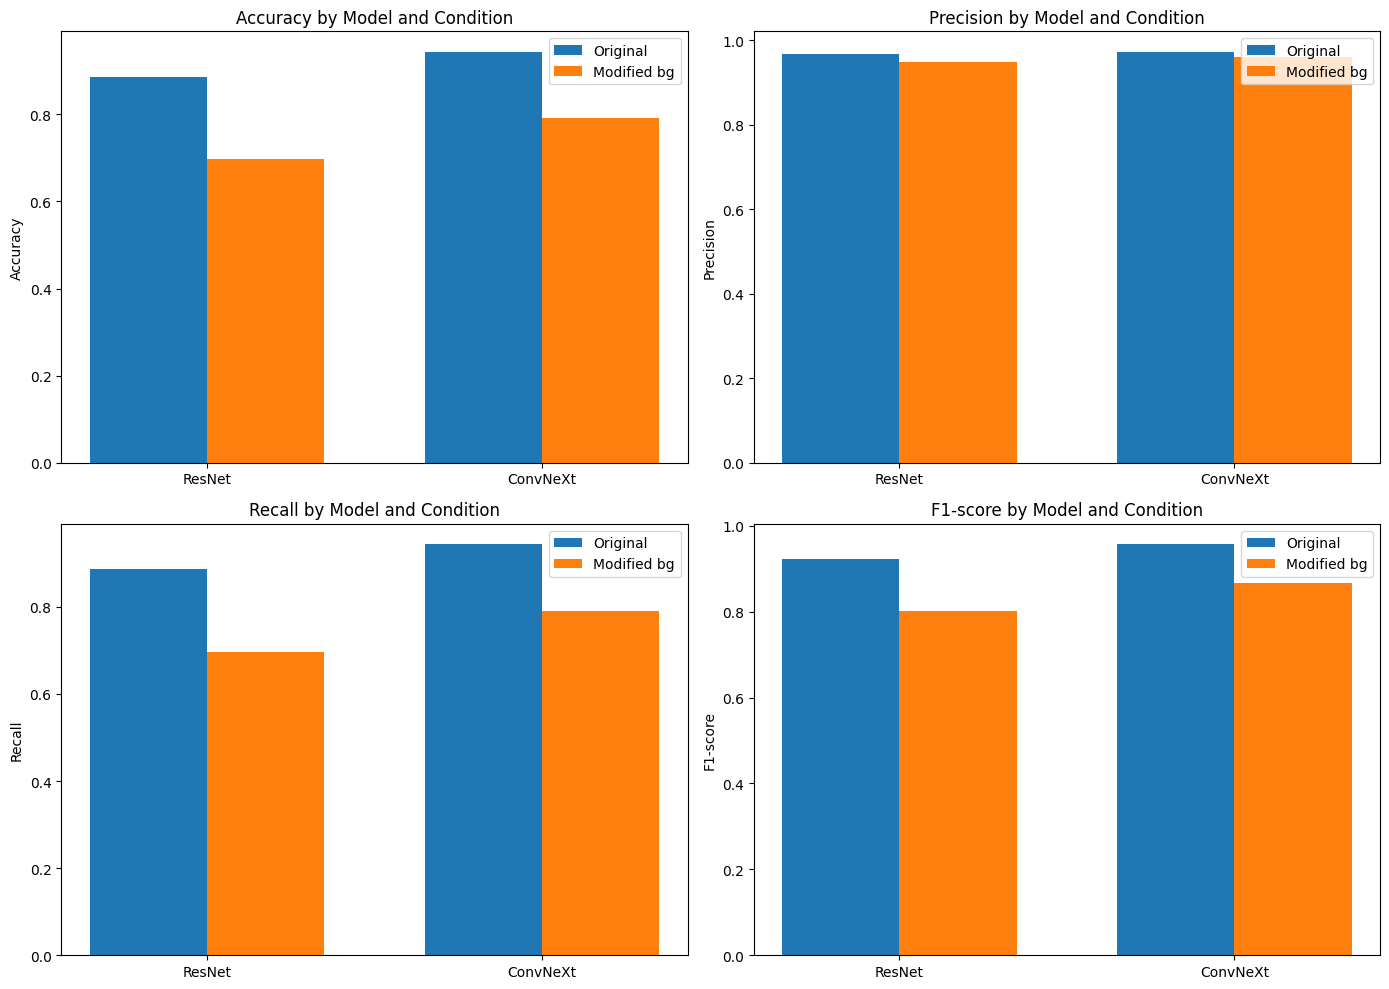

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
x = np.arange(len(results_df['Model'].unique()))
width = 0.35

def create_bar_plot(ax, df, metric_name):
    original = df[df['Type'] == 'Original'][metric_name].values
    modified = df[df['Type'] == 'Modified'][metric_name].values

    rects1 = ax.bar(x - width/2, original, width, label='Original')
    rects2 = ax.bar(x + width/2, modified, width, label='Modified bg')

    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by Model and Condition')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Model'].unique())
    ax.legend()

for idx, metric in enumerate(metrics):
    create_bar_plot(ax[idx//2, idx%2], results_df, metric)

fig.tight_layout()
plt.show()


In [94]:
def calculate_average_scores(df):
    df['true_label'] = df['true_label'].astype(int)
    df['original_prediction'] = df['original_prediction'].astype(int)
    
    avg_original_score = df['original_score'].mean()

    correct_predictions = df[df['original_prediction'] == df['true_label']]
    avg_correct_score = correct_predictions['original_score'].mean()


    incorrect_predictions = df[df['original_prediction'] != df['true_label']]
    avg_incorrect_score = incorrect_predictions['original_score'].mean()

    return avg_original_score, avg_correct_score, avg_incorrect_score

In [95]:
def calculate_average_scores_all_modifications(df):
    score_columns = [col for col in df.columns if col.endswith('_score') and col != 'original_score']
    prediction_columns = [col for col in df.columns if col.endswith('_prediction') and col != 'original_prediction']
    
    all_scores = []
    correct_scores = []
    incorrect_scores = []

    for score_col, pred_col in zip(score_columns, prediction_columns):
        df['true_label'] = df['true_label'].astype(int)
        df[pred_col] = df[pred_col].astype(int)
        
        all_scores.extend(df[score_col])

        correct_predictions = df[df[pred_col] == df['true_label']]
        correct_scores.extend(correct_predictions[score_col])

        incorrect_predictions = df[df[pred_col] != df['true_label']]
        incorrect_scores.extend(incorrect_predictions[score_col])
    

    avg_all_score = sum(all_scores) / len(all_scores)
    avg_correct_score = sum(correct_scores) / len(correct_scores)
    avg_incorrect_score = sum(incorrect_scores) / len(incorrect_scores)

    return avg_all_score, avg_correct_score, avg_incorrect_score

      Model      Type  Average Score  Average Correct Score  \
0    ResNet  Original      85.188854              89.137424   
1    ResNet  Modified      71.694490              83.929904   
2  ConvNeXt  Original      68.527975              70.036361   
3  ConvNeXt  Modified      57.543545              63.189640   

   Average Incorrect Score  
0                54.348263  
1                43.546579  
2                43.433439  
3                36.191272  


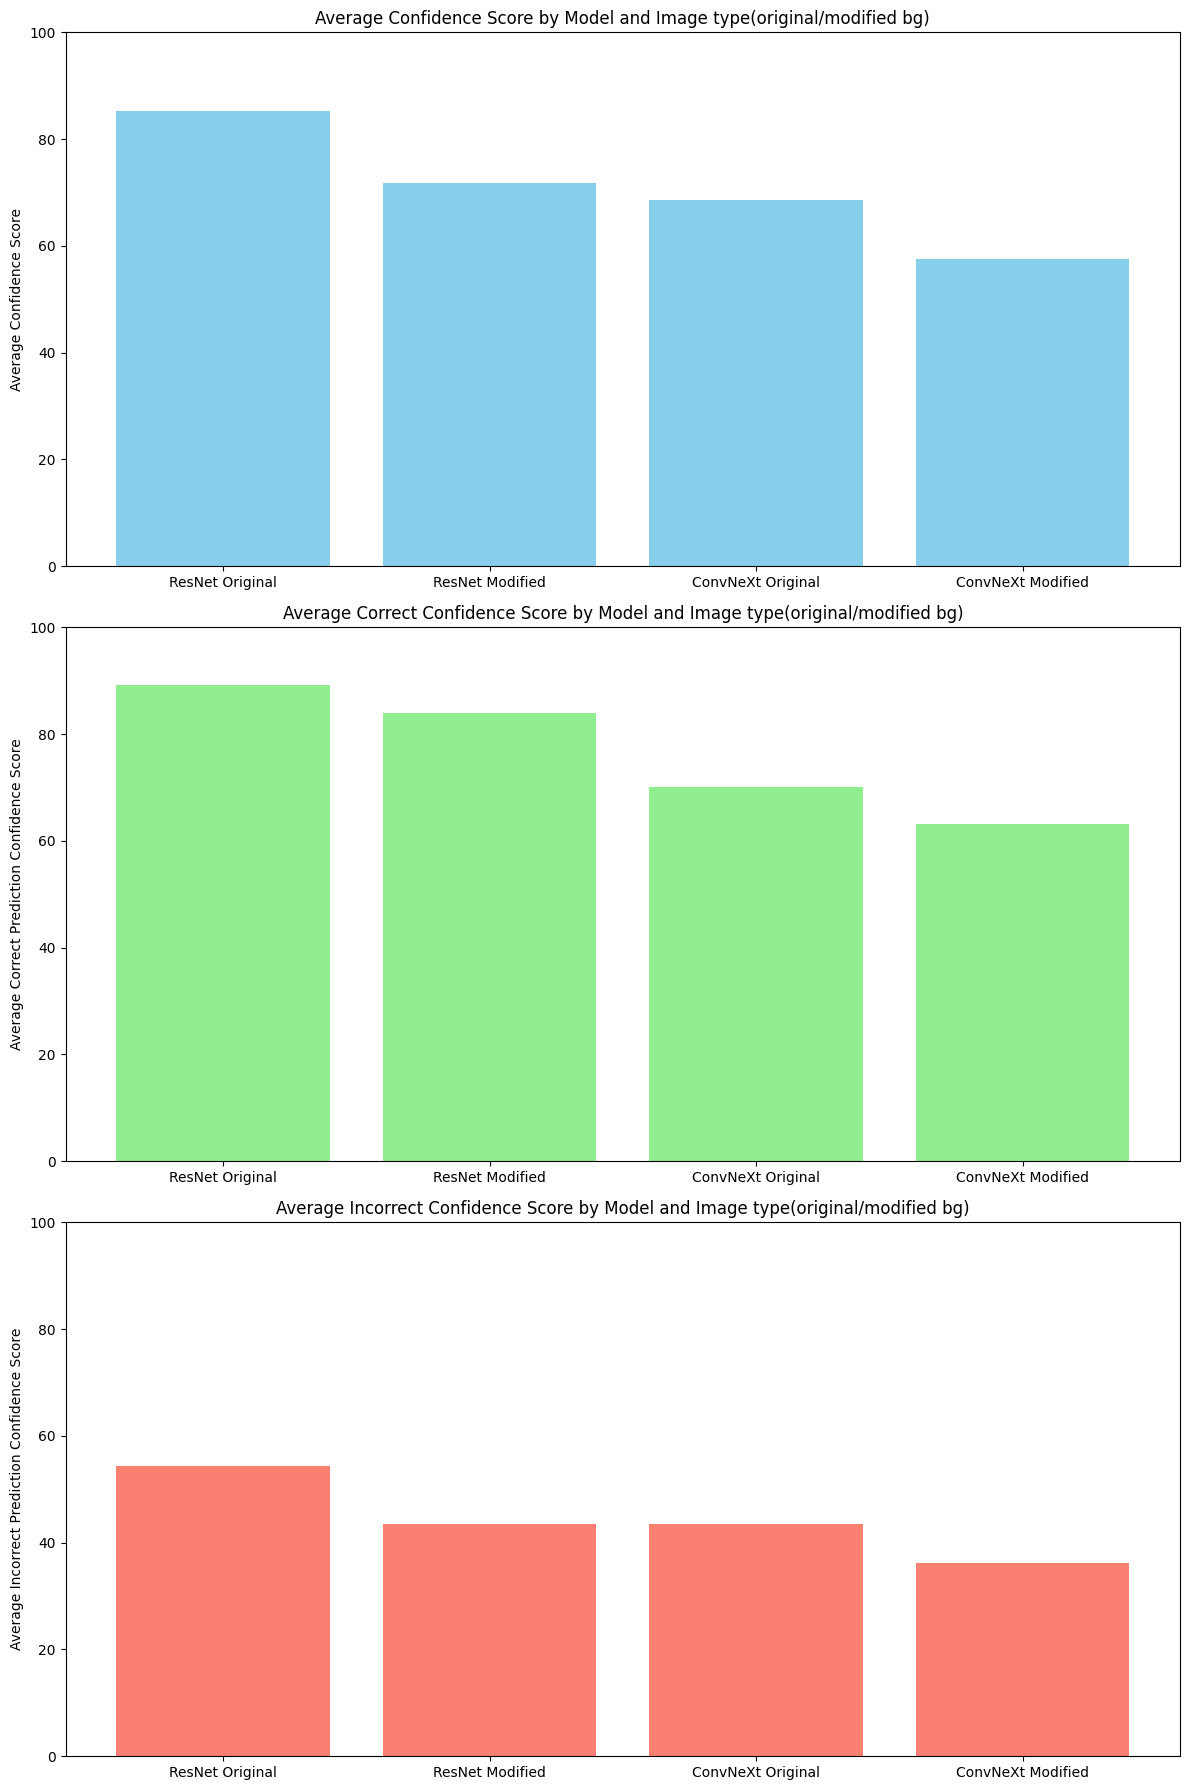

In [96]:
avg_original_resnet, avg_correct_resnet, avg_incorrect_resnet = calculate_average_scores(resnet_df)
avg_mod_resnet, avg_correct_mod_resnet, avg_incorrect_mod_resnet = calculate_average_scores_all_modifications(resnet_df)
avg_original_convnext, avg_correct_convnext, avg_incorrect_convnext = calculate_average_scores(convnext_df)
avg_mod_convnext, avg_correct_mod_convnext, avg_incorrect_mod_convnext = calculate_average_scores_all_modifications(convnext_df)

results_data = {
    'Model': ['ResNet', 'ResNet', 'ConvNeXt', 'ConvNeXt'],
    'Type': ['Original', 'Modified', 'Original', 'Modified'],
    'Average Score': [
        avg_original_resnet, avg_mod_resnet, avg_original_convnext, avg_mod_convnext
    ],
    'Average Correct Score': [
        avg_correct_resnet, avg_correct_mod_resnet, avg_correct_convnext, avg_correct_mod_convnext
    ],
    'Average Incorrect Score': [
        avg_incorrect_resnet, avg_incorrect_mod_resnet, avg_incorrect_convnext, avg_incorrect_mod_convnext
    ]
}

results_df = pd.DataFrame(results_data)
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].bar(results_df['Model'] + ' ' + results_df['Type'], results_df['Average Score'], color='skyblue')
axs[0].set_title('Average Confidence Score by Model and Image type(original/modified bg)')
axs[0].set_ylabel('Average Confidence Score')
axs[0].set_ylim(0, 100)

axs[1].bar(results_df['Model'] + ' ' + results_df['Type'], results_df['Average Correct Score'], color='lightgreen')
axs[1].set_title('Average Correct Confidence Score by Model and Image type(original/modified bg)')
axs[1].set_ylabel('Average Correct Prediction Confidence Score')
axs[1].set_ylim(0, 100)

axs[2].bar(results_df['Model'] + ' ' + results_df['Type'], results_df['Average Incorrect Score'], color='salmon')
axs[2].set_title('Average Incorrect Confidence Score by Model and Image type(original/modified bg)')
axs[2].set_ylabel('Average Incorrect Prediction Confidence Score')
axs[2].set_ylim(0, 100)

print(results_df)
plt.tight_layout()
plt.show()

In [97]:
save_df(resnet_df, resnet_results_path)
save_df(convnext_df, convnext_results_path)

In [98]:
resnet_df.head()

object_percentage_category  true_label true_label_description  \
0                      small         348               ram, tup   
1                     medium         348               ram, tup   
2                      large         348               ram, tup   
3                      large         348               ram, tup   
4                     medium         348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       58.839279                  349     80.977097                348   
1       75.892090                  348     22.872158                348   
2       81.076469                  348     93.878342                348   
3       53.754341                  348     70.883713                349   
4       89.708168                  349     87.256088                349   

   low_score  low_prediction  city_score  city_prediction  sky_score  \
0  50.551521             349   69.934639              348  82.987450   
1  69.402061             348   88.528374              348  69.020668   
2  62.501762             348   58.977772              348  94.132629   
3  62.867821             349   50.269855              348  60.222435   
4  83.907135             349   83.456581              349  82.660828   

   sky_prediction  jungle_score  jungle_prediction   no_score  no_prediction  \
0             348     72.272240                348  29.558765            240   
1             348     65.185081                348  34.195347            295   
2             348     95.790382                348  56.970715            295   
3             349     52.651096                348  11.731533            649   
4             349     65.849808                349  91.065613            349   

   high_score  high_prediction  water_score  water_prediction  snow_score  \
0   87.865593              348    79.904648               348   67.014305   
1   86.046425              348    51.148842               348   80.982758   
2   87.129959              348    95.263901               348   75.683281   
3   58.879681              349    50.064980               349   70.590103   
4   77.554497              349    67.722954               349   88.169632   

   snow_prediction  indoor_score  indoor_prediction  mountain_score  \
0              349     26.773108                453       77.038040   
1              348     16.747709                 87       92.803429   
2              348     89.990028                348       93.176178   
3              349     59.058559                349       68.489357   
4              349     74.471443                349       88.701241   

   mountain_prediction  
0                  349  
1                  348  
2                  348  
3                  349  
4                  349

In [99]:
def define_columns(df):
    prediction_columns = [col for col in df.columns if col.endswith('_prediction')]
    confidence_columns = [col for col in df.columns if col.endswith('_score')]
    return prediction_columns, confidence_columns


In [100]:
def correlation_analysis(df, confidence_columns):
    confidence_df = df[confidence_columns]  # Exclude 'object_percentage_category'
    correlations = confidence_df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Confidence Scores')
    plt.show()

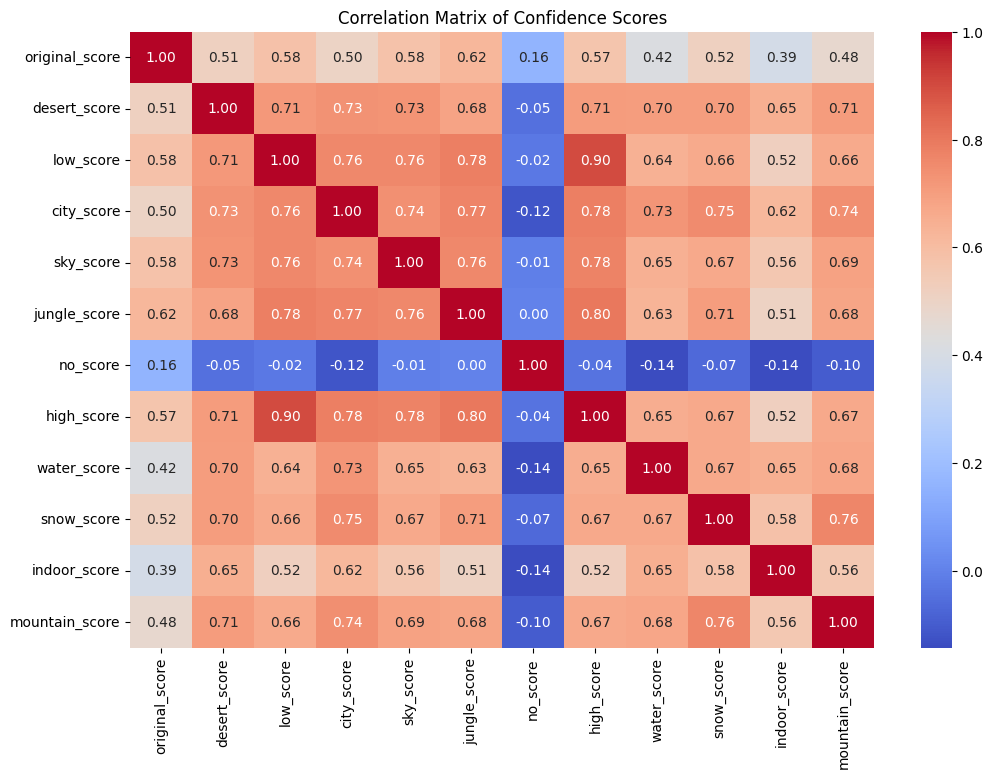

In [101]:
pred, conf = define_columns(resnet_df)
correlation_analysis(resnet_df, conf)

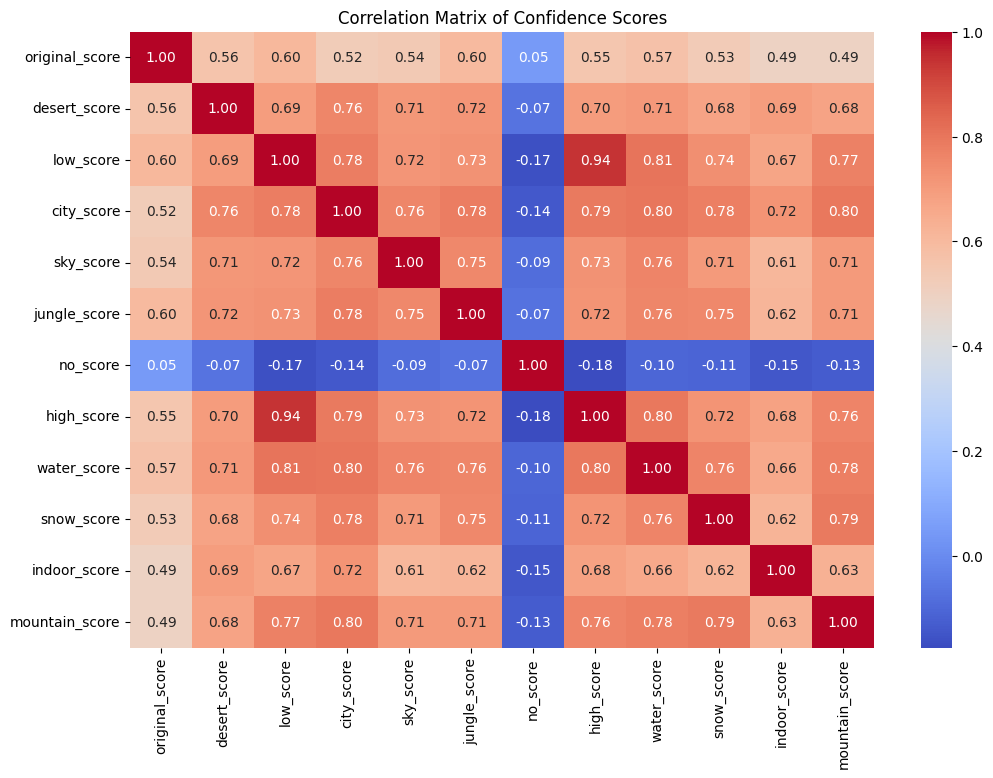

In [102]:
pred, conf = define_columns(convnext_df)
correlation_analysis(convnext_df, conf)

In [103]:
def confidence_score_distribution(df, prediction_columns, confidence_columns):
    df['true_label'] = df['true_label'].astype(int)
    for col in prediction_columns:
        df[col] = df[col].astype(int)

    def is_correct_prediction(row, prediction_col, true_label_col='true_label'):
        return row[true_label_col] == row[prediction_col]

    for pred_col in prediction_columns:
        df[pred_col + '_correct'] = df.apply(lambda row: is_correct_prediction(row, pred_col), axis=1)

    correct_confidences = []
    incorrect_confidences = []

    for score_col, pred_col in zip(confidence_columns, prediction_columns):
        correct_confidences.extend(df[df[pred_col + '_correct']][score_col].dropna().tolist())
        incorrect_confidences.extend(df[~df[pred_col + '_correct']][score_col].dropna().tolist())

    plt.figure(figsize=(12, 6))
    sns.histplot(correct_confidences, color='green', label='Correct Predictions', kde=True, stat="density")
    sns.histplot(incorrect_confidences, color='red', label='Incorrect Predictions', kde=True, stat="density")
    plt.title('Distribution of Confidence Scores for Correct vs Incorrect Predictions')
    plt.xlabel('Confidence Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [104]:
resnet_df.head()

object_percentage_category  true_label true_label_description  \
0                      small         348               ram, tup   
1                     medium         348               ram, tup   
2                      large         348               ram, tup   
3                      large         348               ram, tup   
4                     medium         348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       58.839279                  349     80.977097                348   
1       75.892090                  348     22.872158                348   
2       81.076469                  348     93.878342                348   
3       53.754341                  348     70.883713                349   
4       89.708168                  349     87.256088                349   

   low_score  low_prediction  city_score  city_prediction  sky_score  \
0  50.551521             349   69.934639              348  82.987450   
1  69.402061             348   88.528374              348  69.020668   
2  62.501762             348   58.977772              348  94.132629   
3  62.867821             349   50.269855              348  60.222435   
4  83.907135             349   83.456581              349  82.660828   

   sky_prediction  jungle_score  jungle_prediction   no_score  no_prediction  \
0             348     72.272240                348  29.558765            240   
1             348     65.185081                348  34.195347            295   
2             348     95.790382                348  56.970715            295   
3             349     52.651096                348  11.731533            649   
4             349     65.849808                349  91.065613            349   

   high_score  high_prediction  water_score  water_prediction  snow_score  \
0   87.865593              348    79.904648               348   67.014305   
1   86.046425              348    51.148842               348   80.982758   
2   87.129959              348    95.263901               348   75.683281   
3   58.879681              349    50.064980               349   70.590103   
4   77.554497              349    67.722954               349   88.169632   

   snow_prediction  indoor_score  indoor_prediction  mountain_score  \
0              349     26.773108                453       77.038040   
1              348     16.747709                 87       92.803429   
2              348     89.990028                348       93.176178   
3              349     59.058559                349       68.489357   
4              349     74.471443                349       88.701241   

   mountain_prediction  
0                  349  
1                  348  
2                  348  
3                  349  
4                  349

In [105]:
convnext_df.head()

object_percentage_category  true_label true_label_description  \
0                      small         348               ram, tup   
1                     medium         348               ram, tup   
2                      large         348               ram, tup   
3                      large         348               ram, tup   
4                     medium         348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       46.373386                  349     39.178246                349   
1       78.177628                  348     78.905365                348   
2       79.154984                  348     75.236961                348   
3       40.402241                  348     41.739841                349   
4       49.981297                  349     44.770977                349   

   low_score  low_prediction  city_score  city_prediction  sky_score  \
0  35.915047             349   36.261684              349  32.841434   
1  81.804100             348   85.499680              348  77.875259   
2  77.332947             348   73.829636              348  77.585464   
3  37.637833             348   39.782448              349  36.871704   
4  32.670235             348   42.254787              349  34.506985   

   sky_prediction  jungle_score  jungle_prediction   no_score  no_prediction  \
0             348     34.654091                349  32.191479            348   
1             348     84.753433                348  30.929214            825   
2             348     79.860634                348  52.488834              8   
3             348     33.927750                348  30.554974            295   
4             349     33.637314                349  64.156876            349   

   high_score  high_prediction  water_score  water_prediction  snow_score  \
0   35.655186              349    33.616207               349   52.296246   
1   80.494812              348    81.612816               348   81.916199   
2   73.709946              348    76.116119               348   58.095898   
3   37.928951              348    39.006672               349   43.786774   
4   33.935677              349    35.364922               349   44.977673   

   snow_prediction  indoor_score  indoor_prediction  mountain_score  \
0              349     34.621975                349       49.499184   
1              348     81.708229                348       85.559204   
2              348     73.713272                348       64.670166   
3              349     41.510838                349       39.187191   
4              349     47.262661                349       44.087524   

   mountain_prediction  
0                  349  
1                  348  
2                  348  
3                  349  
4                  349

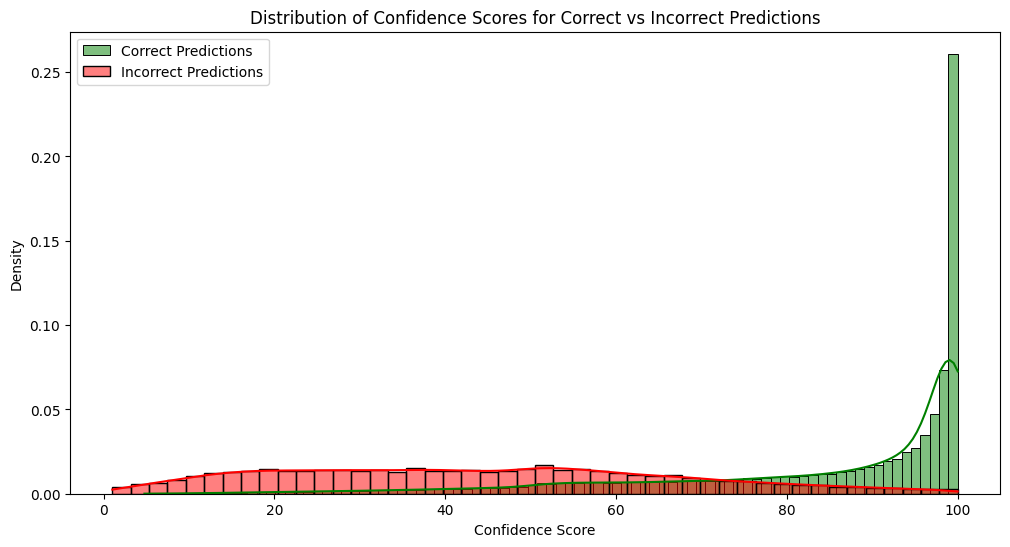

In [106]:
prediction_columns, confidence_columns = define_columns(resnet_df)

confidence_score_distribution(resnet_df, prediction_columns, confidence_columns)

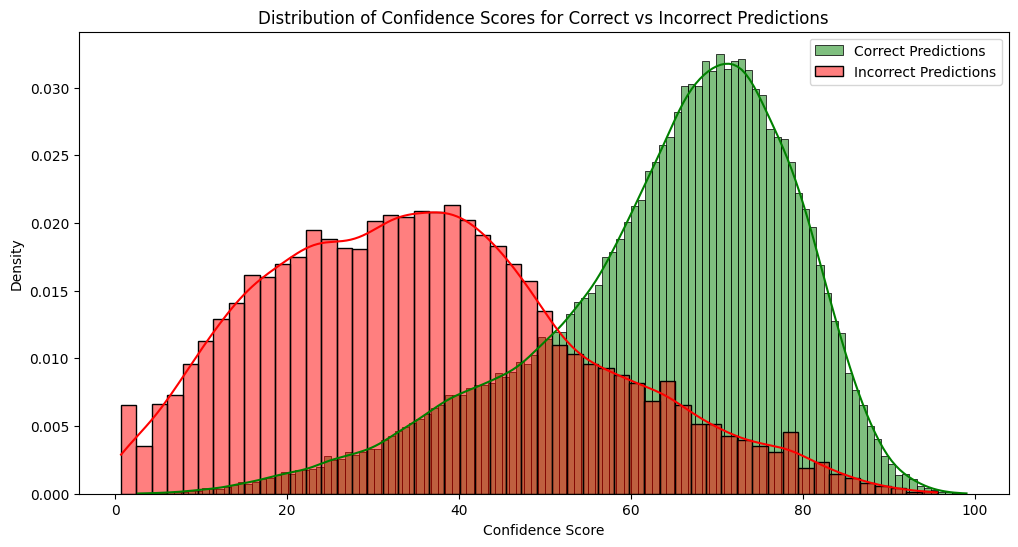

In [107]:
prediction_columns, confidence_columns = define_columns(convnext_df)

confidence_score_distribution(convnext_df, prediction_columns, confidence_columns)

In [108]:
resnet_results_path = os.path.join('results', 'resnet_df.pkl')
convnext_results_path = os.path.join('results', 'convnext_df.pkl')
save_df(resnet_df, resnet_results_path)
save_df(convnext_df, convnext_results_path)

In [109]:
resnet_df = load_df(resnet_results_path)
convnext_df = load_df(convnext_results_path)

In [110]:
resnet_df.head()

object_percentage_category  true_label true_label_description  \
0                      small         348               ram, tup   
1                     medium         348               ram, tup   
2                      large         348               ram, tup   
3                      large         348               ram, tup   
4                     medium         348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       58.839279                  349     80.977097                348   
1       75.892090                  348     22.872158                348   
2       81.076469                  348     93.878342                348   
3       53.754341                  348     70.883713                349   
4       89.708168                  349     87.256088                349   

   low_score  low_prediction  city_score  city_prediction  sky_score  \
0  50.551521             349   69.934639              348  82.987450   
1  69.402061             348   88.528374              348  69.020668   
2  62.501762             348   58.977772              348  94.132629   
3  62.867821             349   50.269855              348  60.222435   
4  83.907135             349   83.456581              349  82.660828   

   sky_prediction  jungle_score  jungle_prediction   no_score  no_prediction  \
0             348     72.272240                348  29.558765            240   
1             348     65.185081                348  34.195347            295   
2             348     95.790382                348  56.970715            295   
3             349     52.651096                348  11.731533            649   
4             349     65.849808                349  91.065613            349   

   high_score  high_prediction  water_score  water_prediction  snow_score  \
0   87.865593              348    79.904648               348   67.014305   
1   86.046425              348    51.148842               348   80.982758   
2   87.129959              348    95.263901               348   75.683281   
3   58.879681              349    50.064980               349   70.590103   
4   77.554497              349    67.722954               349   88.169632   

   snow_prediction  indoor_score  indoor_prediction  mountain_score  \
0              349     26.773108                453       77.038040   
1              348     16.747709                 87       92.803429   
2              348     89.990028                348       93.176178   
3              349     59.058559                349       68.489357   
4              349     74.471443                349       88.701241   

   mountain_prediction  original_prediction_correct  \
0                  349                        False   
1                  348                         True   
2                  348                         True   
3                  349                         True   
4                  349                        False   

   desert_prediction_correct  low_prediction_correct  city_prediction_correct  \
0                       True                   False                     True   
1                       True                    True                     True   
2                       True                    True                     True   
3                      False                   False                     True   
4                      False                   False                    False   

   sky_prediction_correct  jungle_prediction_correct  no_prediction_correct  \
0                    True                       True                  False   
1                    True                       True                  False   
2                    True                       True                  False   
3                   False                       True                  False   
4                   False                      False                  False   

   high_prediction_correct  water_prediction_correc

   Class Background  Accuracy  Precision    Recall  F1-Score
0    348   original     0.781   0.052632  0.041105  0.046160
1    238   original     0.746   0.021739  0.016217  0.018577
2     94   original     0.963   0.041667  0.040125  0.040881
3    285   original     0.782   0.027027  0.021135  0.023721
4    349   original     0.857   0.071429  0.061214  0.065928
..   ...        ...       ...        ...       ...       ...
5    229   mountain     0.715   0.016667  0.011917  0.013897
6    283   mountain     0.794   0.020833  0.016542  0.018441
7     13   mountain     0.797   0.037037  0.029519  0.032853
8    235   mountain     0.666   0.014493  0.009652  0.011587
9     15   mountain     0.879   0.043478  0.038217  0.040678

[120 rows x 6 columns]


/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

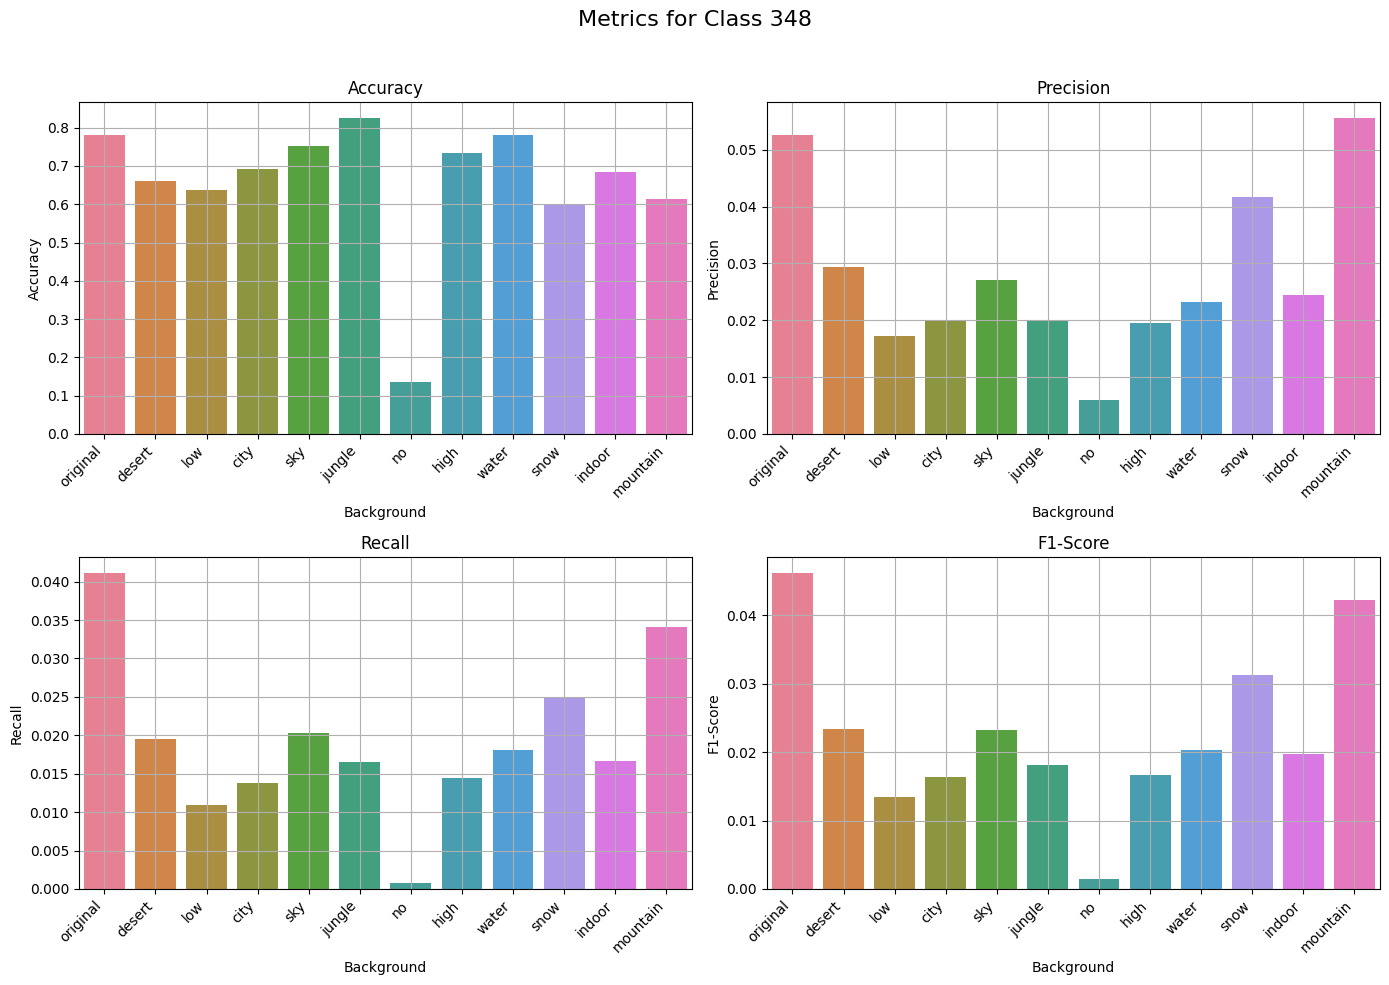

/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

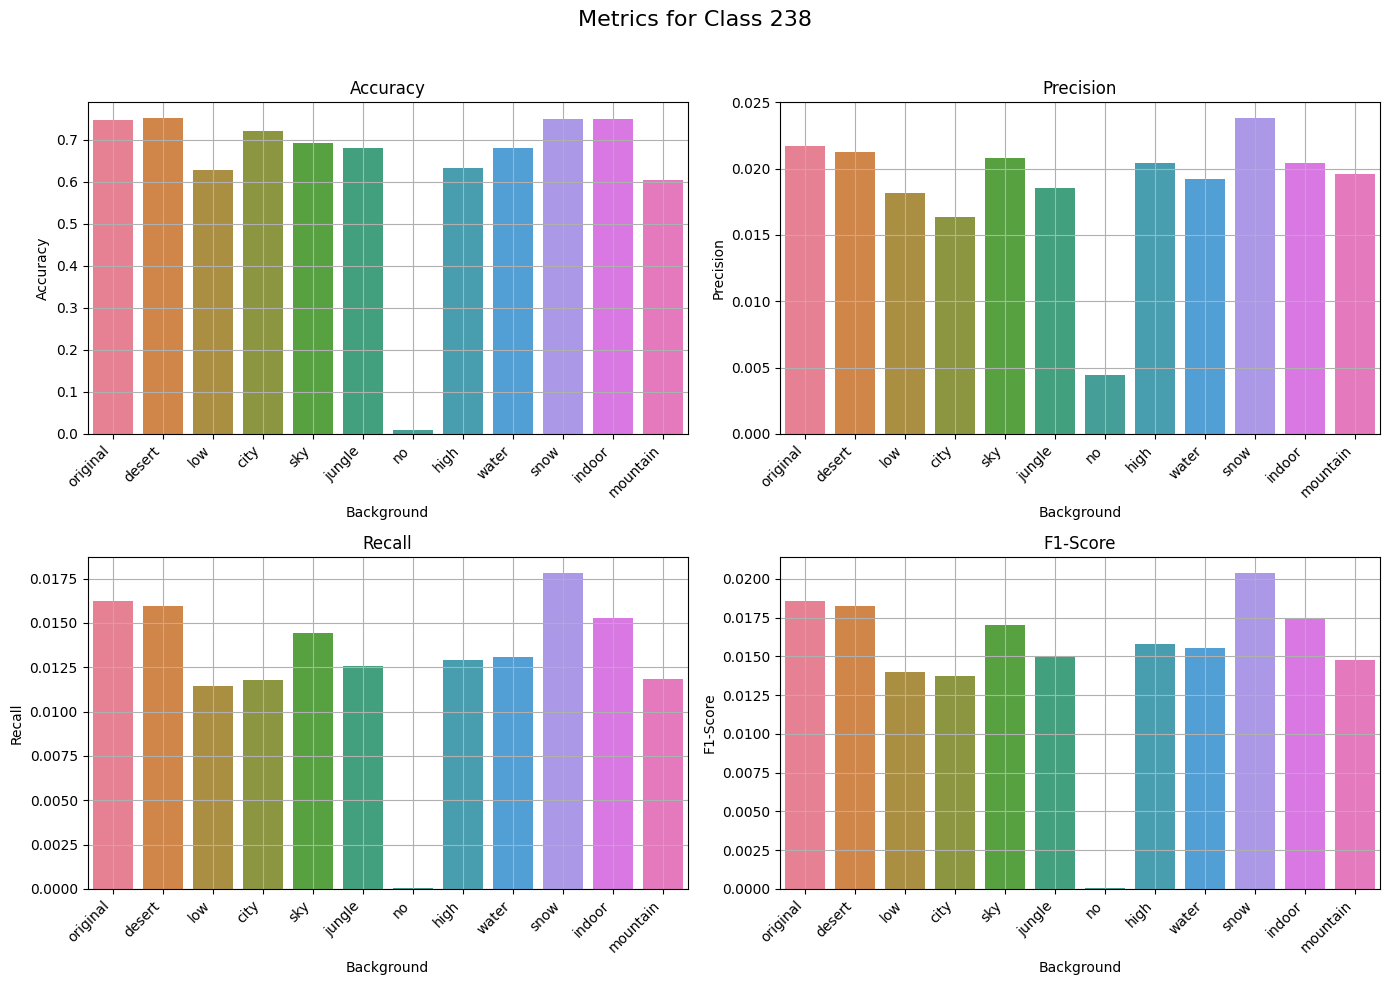

/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

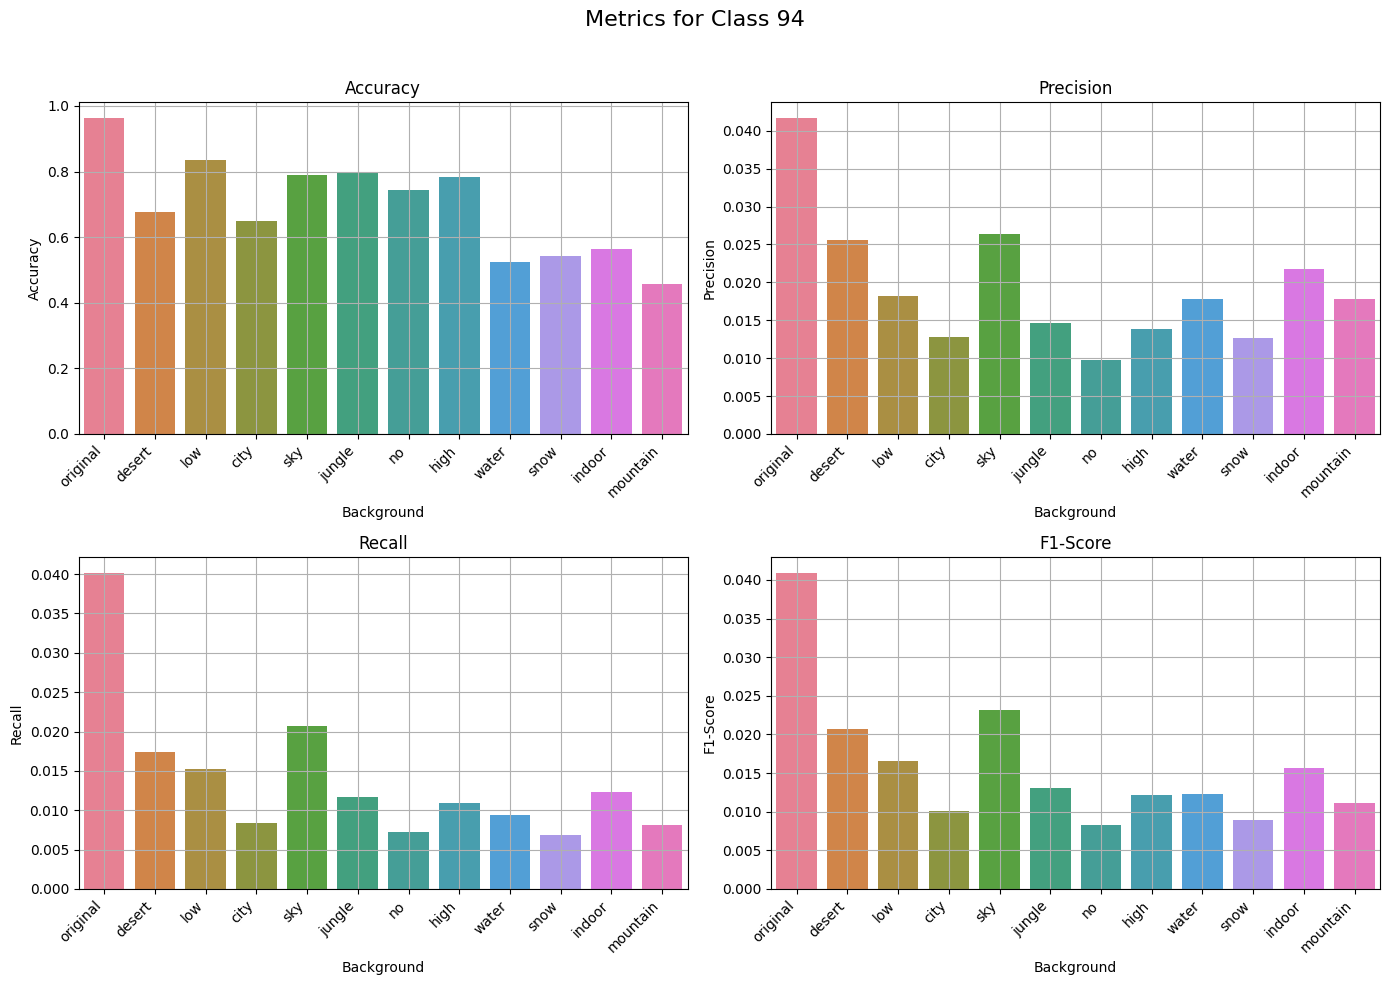

/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

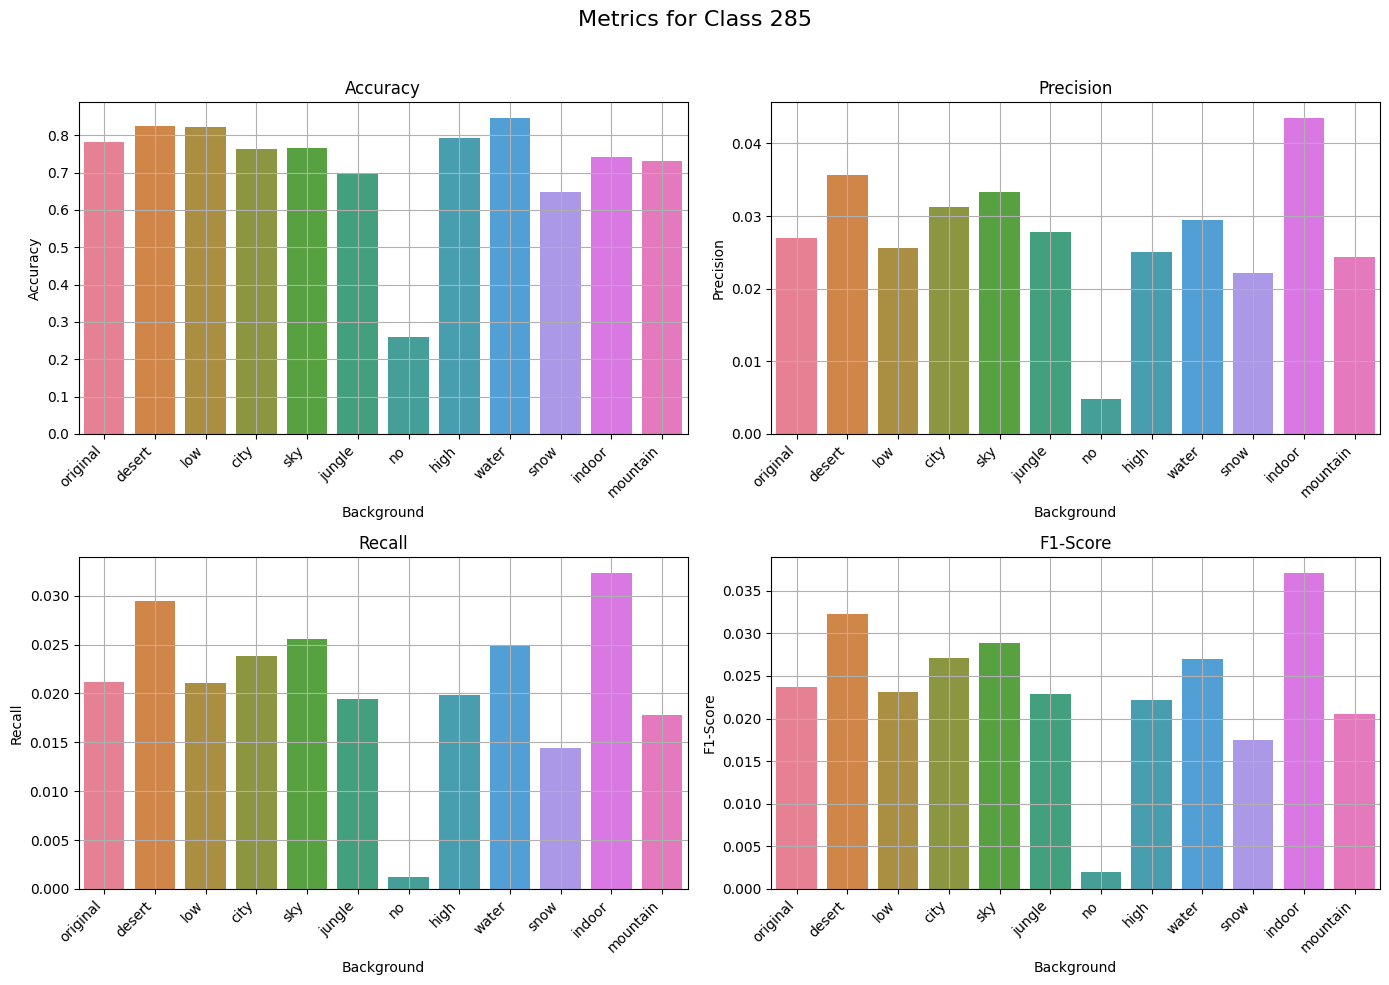

/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

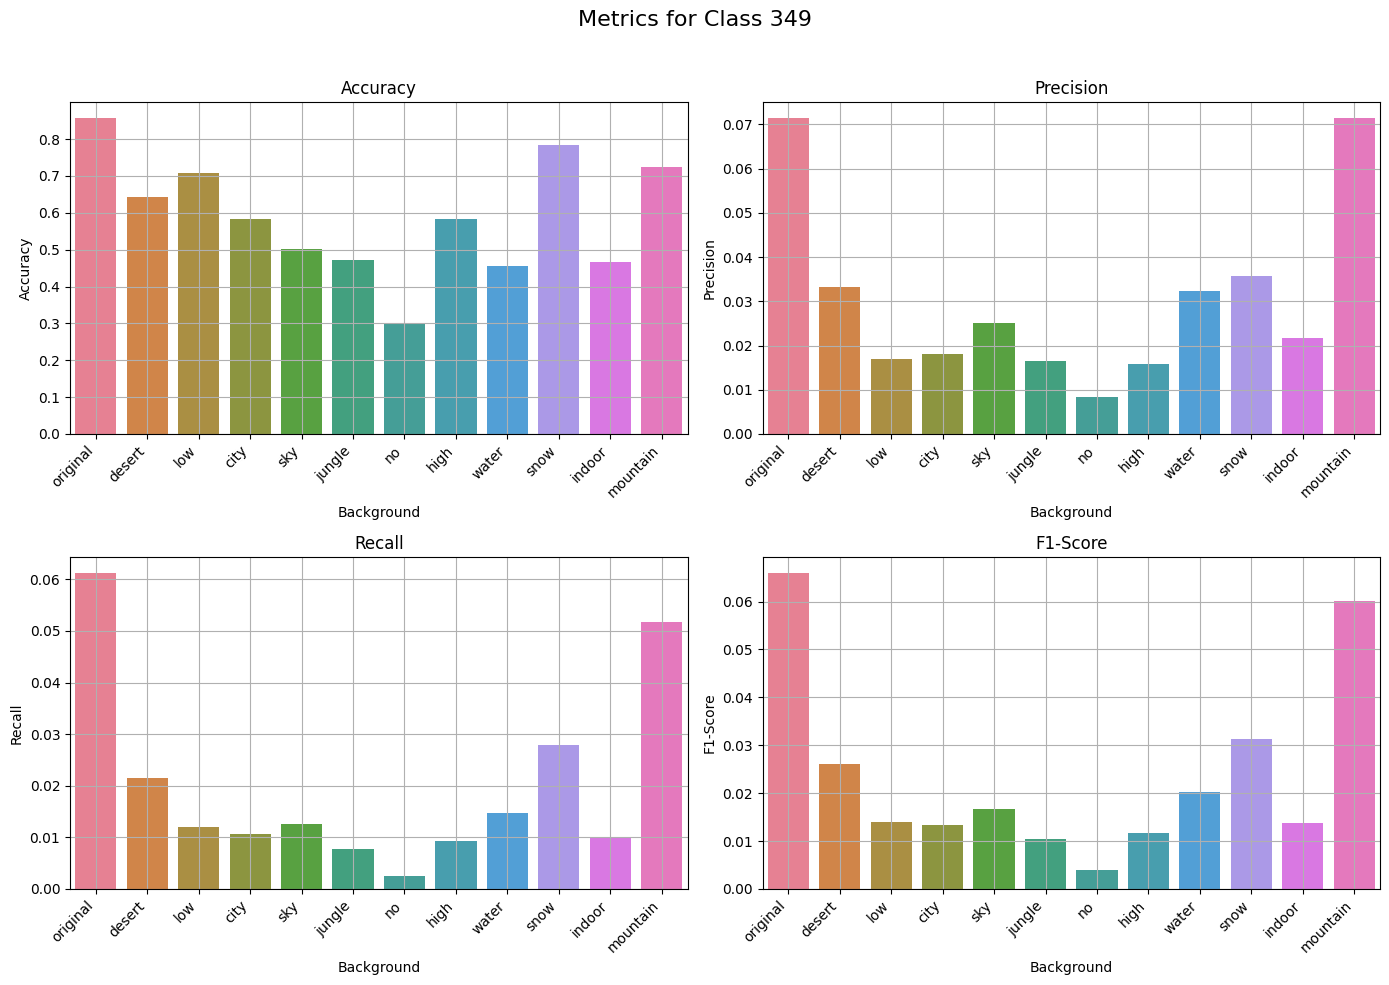

/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

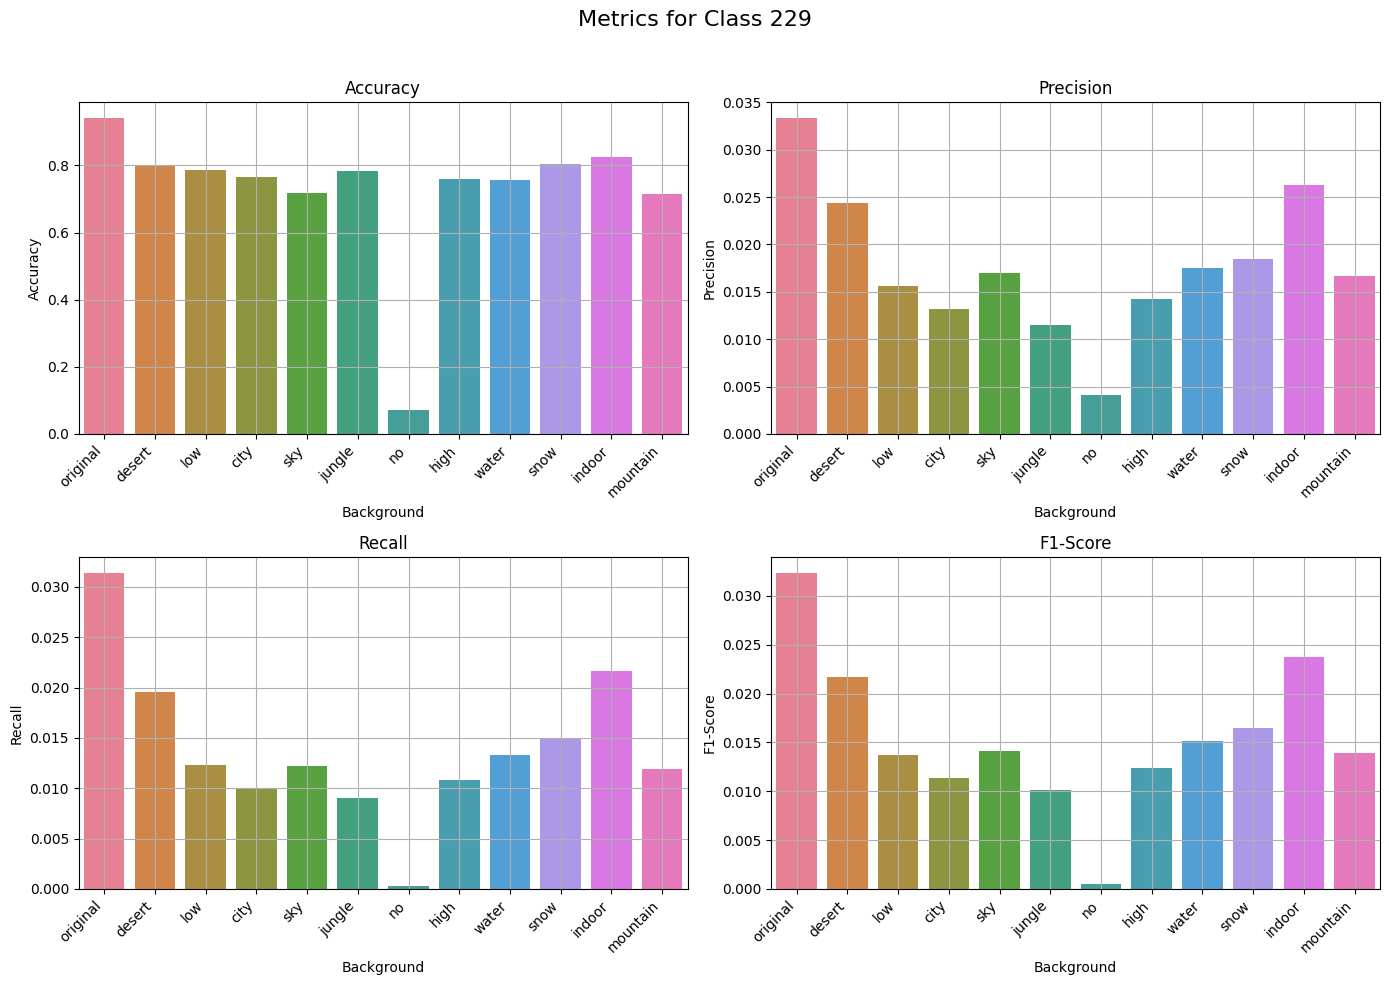

/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

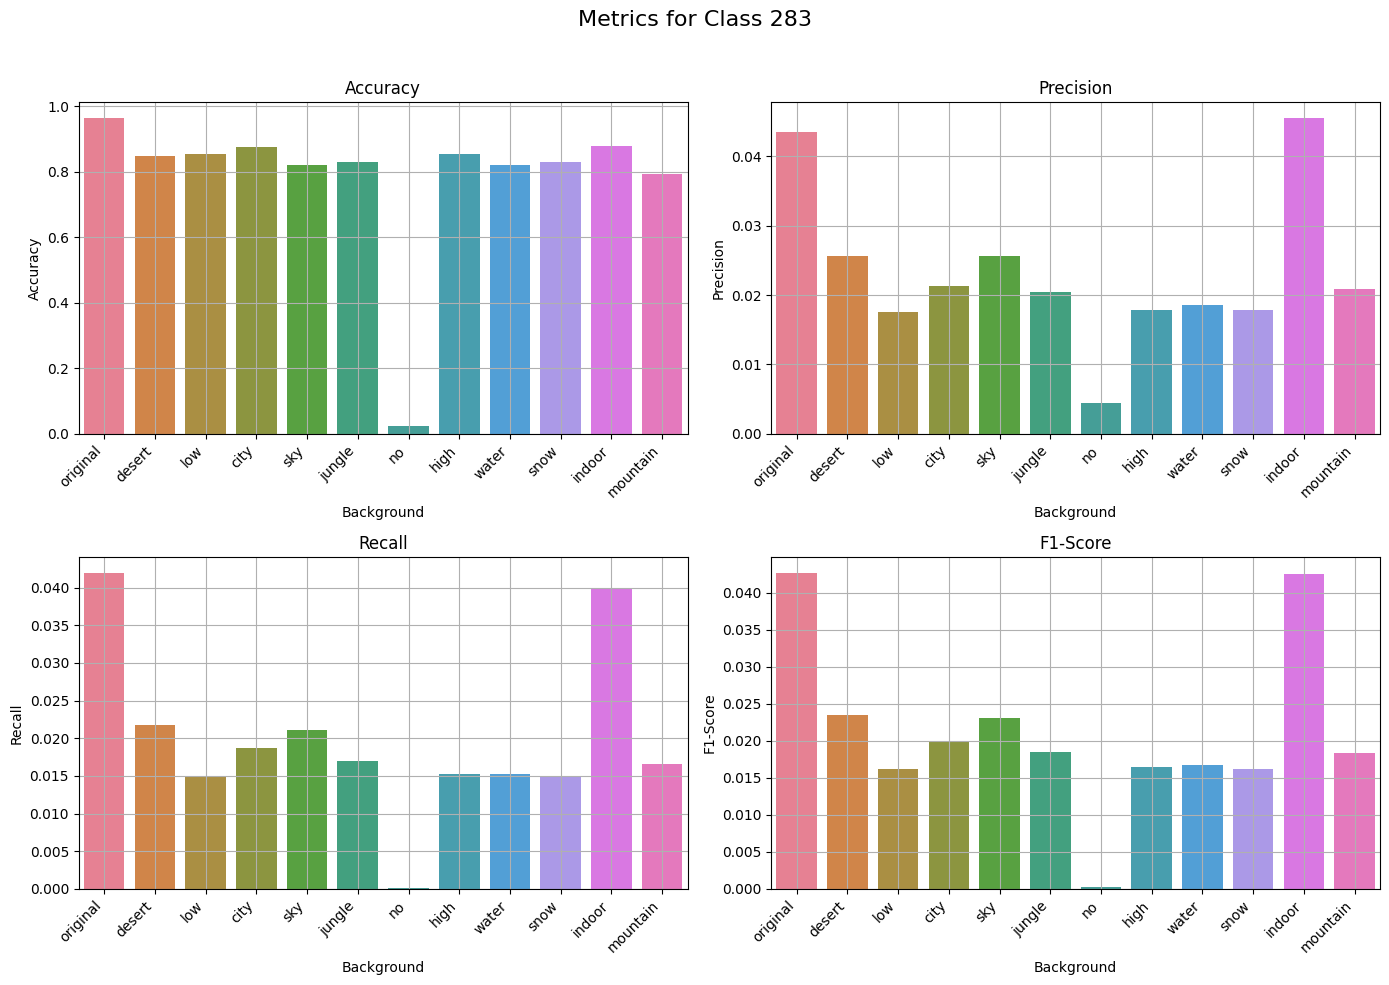

/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

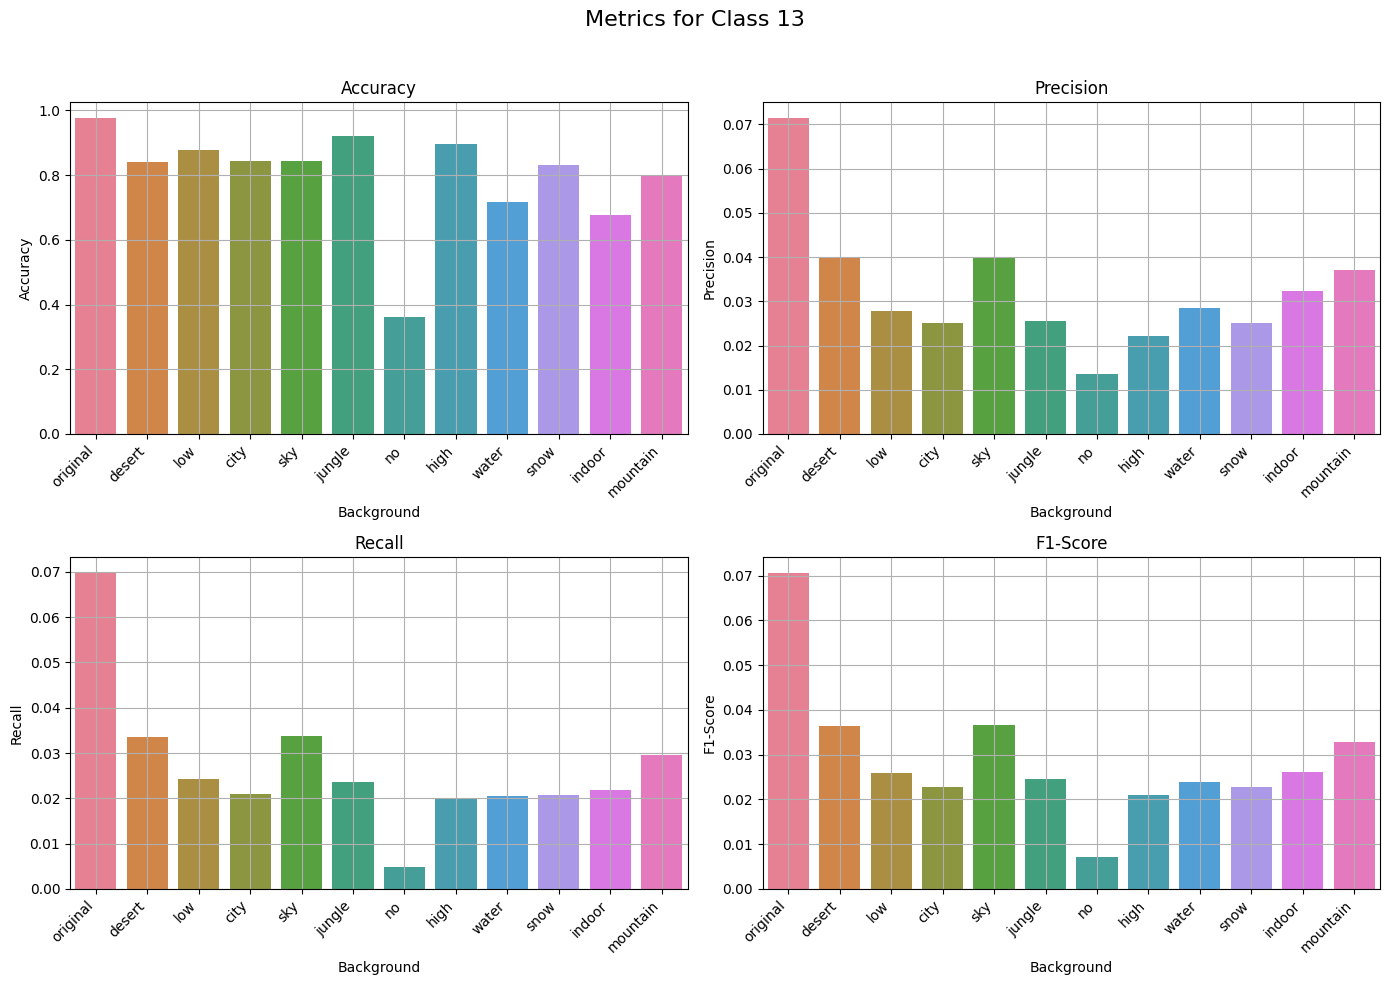

/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

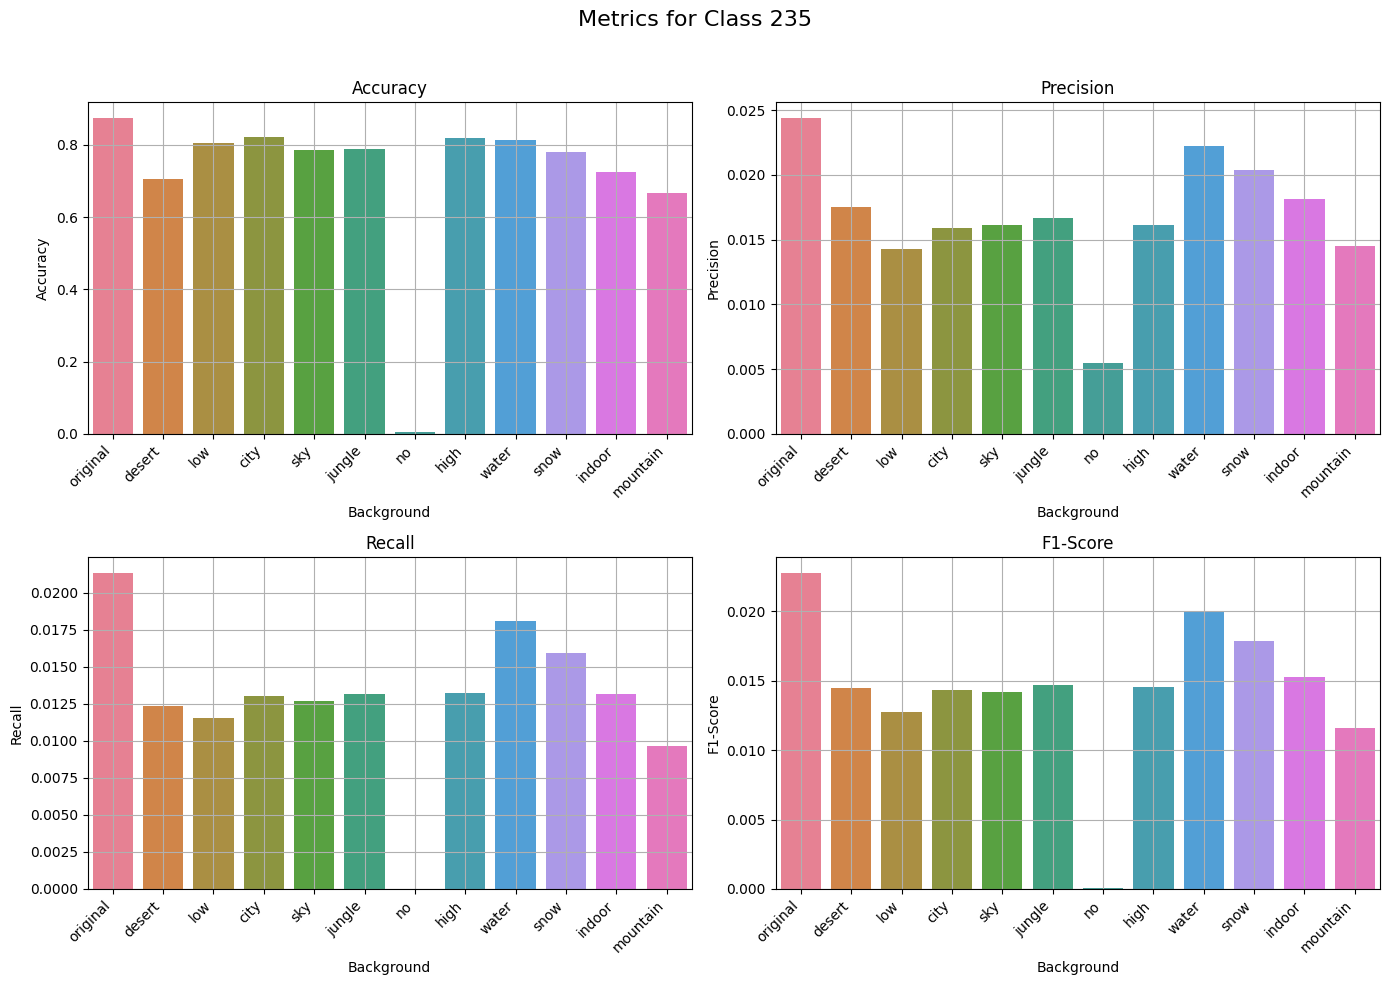

/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_4690/4133615753.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_4690/4133615753.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

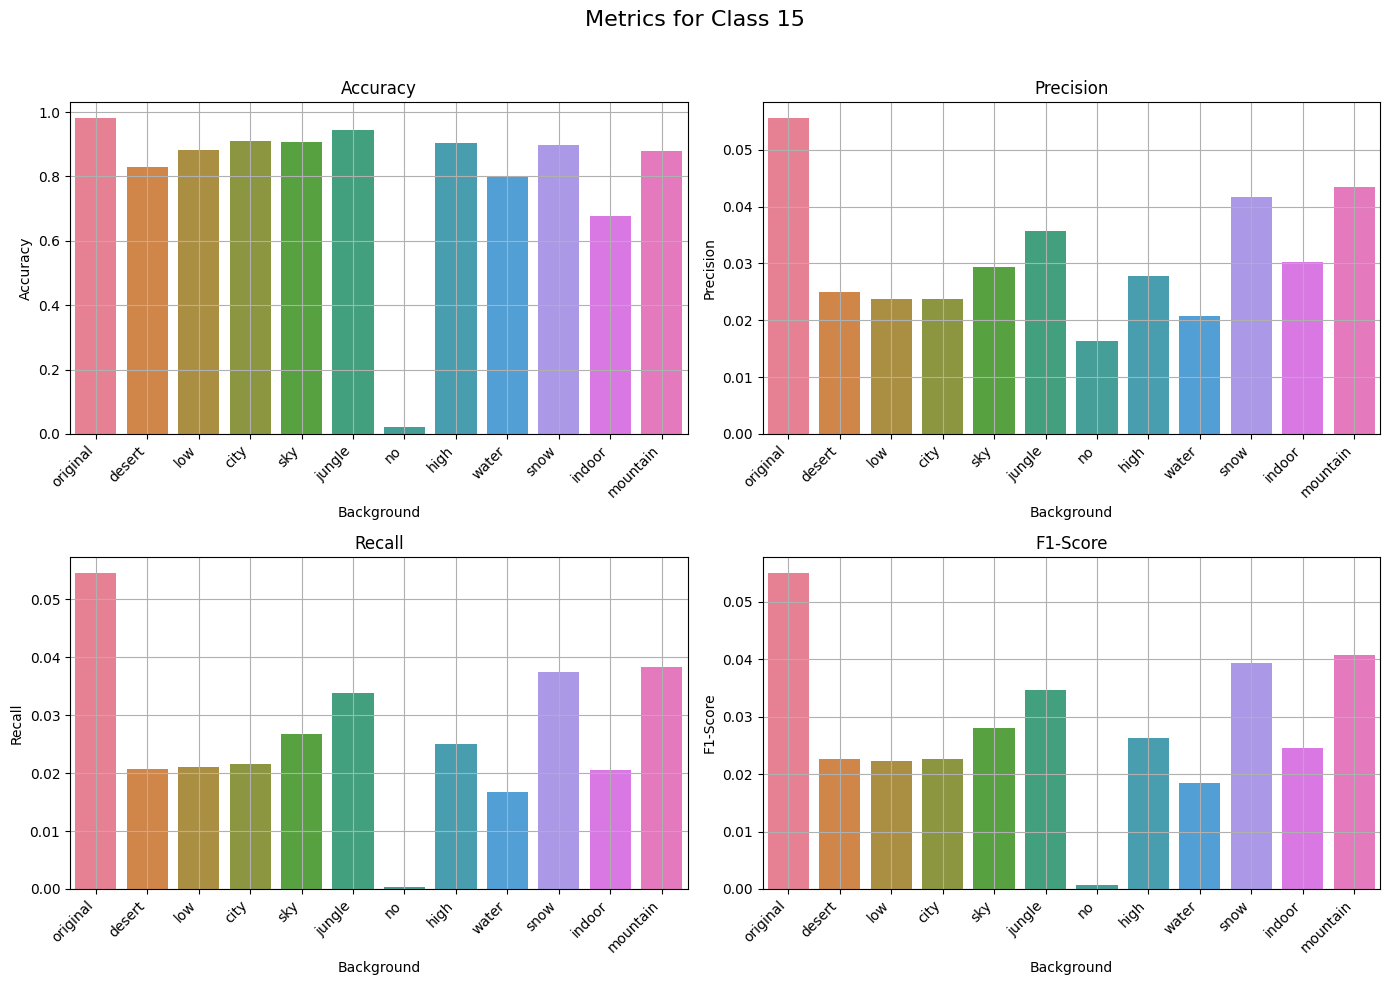

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(df, background):
    metrics = []
    unique_labels = df['true_label'].unique()
    
    for label in unique_labels:
        true_labels = df[df['true_label'] == label]['true_label']
        pred_labels = df[df['true_label'] == label][f'{background}_prediction']
        
        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
        recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
        f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
        
        metrics.append({
            'Class': label,
            'Background': background,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
    
    return pd.DataFrame(metrics)

backgrounds = ['original', 'desert', 'low', 'city', 'sky', 'jungle', 'no', 'high', 'water', 'snow', 'indoor', 'mountain']

metrics_df_list = [calculate_metrics(resnet_df, bg) for bg in backgrounds]
metrics_df = pd.concat(metrics_df_list)

metrics_df['Class'] = metrics_df['Class'].astype('category')

print(metrics_df)



def plot_metrics_for_class(df, class_label, metrics):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Metrics for Class {class_label}', fontsize=16)
    
    palette = sns.color_palette("husl", len(df['Background'].unique()))
    for ax, metric in zip(axes.flatten(), metrics):
        subset = df[df['Class'] == class_label]
        sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
        ax.set_title(metric)
        ax.set_xlabel('Background')
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for class_label in metrics_df['Class'].unique():
    plot_metrics_for_class(metrics_df, class_label, metrics)



In [112]:
resnet_df.head()

object_percentage_category  true_label true_label_description  \
0                      small         348               ram, tup   
1                     medium         348               ram, tup   
2                      large         348               ram, tup   
3                      large         348               ram, tup   
4                     medium         348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       58.839279                  349     80.977097                348   
1       75.892090                  348     22.872158                348   
2       81.076469                  348     93.878342                348   
3       53.754341                  348     70.883713                349   
4       89.708168                  349     87.256088                349   

   low_score  low_prediction  city_score  city_prediction  sky_score  \
0  50.551521             349   69.934639              348  82.987450   
1  69.402061             348   88.528374              348  69.020668   
2  62.501762             348   58.977772              348  94.132629   
3  62.867821             349   50.269855              348  60.222435   
4  83.907135             349   83.456581              349  82.660828   

   sky_prediction  jungle_score  jungle_prediction   no_score  no_prediction  \
0             348     72.272240                348  29.558765            240   
1             348     65.185081                348  34.195347            295   
2             348     95.790382                348  56.970715            295   
3             349     52.651096                348  11.731533            649   
4             349     65.849808                349  91.065613            349   

   high_score  high_prediction  water_score  water_prediction  snow_score  \
0   87.865593              348    79.904648               348   67.014305   
1   86.046425              348    51.148842               348   80.982758   
2   87.129959              348    95.263901               348   75.683281   
3   58.879681              349    50.064980               349   70.590103   
4   77.554497              349    67.722954               349   88.169632   

   snow_prediction  indoor_score  indoor_prediction  mountain_score  \
0              349     26.773108                453       77.038040   
1              348     16.747709                 87       92.803429   
2              348     89.990028                348       93.176178   
3              349     59.058559                349       68.489357   
4              349     74.471443                349       88.701241   

   mountain_prediction  original_prediction_correct  \
0                  349                        False   
1                  348                         True   
2                  348                         True   
3                  349                         True   
4                  349                        False   

   desert_prediction_correct  low_prediction_correct  city_prediction_correct  \
0                       True                   False                     True   
1                       True                    True                     True   
2                       True                    True                     True   
3                      False                   False                     True   
4                      False                   False                    False   

   sky_prediction_correct  jungle_prediction_correct  no_prediction_correct  \
0                    True                       True                  False   
1                    True                       True                  False   
2                    True                       True                  False   
3                   False                       True                  False   
4                   False                      False                  False   

   high_prediction_correct  water_prediction_correc

In [126]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(df, true_label_col, exclude_col, object_size_col):
    metrics = {
        'object_size': [],
        'dataset_type': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
    
    modified_predictions_cols = [col for col in df.columns if col.endswith('_prediction') and col != exclude_col]

    grouped = df.groupby(object_size_col)
    
    for name, group in grouped:
        true_labels = group[true_label_col]
        
        original_predictions = group[exclude_col]
        metrics['object_size'].append(name)
        metrics['dataset_type'].append('original')
        metrics['accuracy'].append(accuracy_score(true_labels, original_predictions))
        metrics['precision'].append(precision_score(true_labels, original_predictions, average='weighted', zero_division=0))
        metrics['recall'].append(recall_score(true_labels, original_predictions, average='weighted', zero_division=0))
        metrics['f1_score'].append(f1_score(true_labels, original_predictions, average='weighted', zero_division=0))

        all_modified_predictions = []
        for col in modified_predictions_cols:
            all_modified_predictions.extend(group[col])

        repeated_true_labels = pd.concat([true_labels] * len(modified_predictions_cols)).reset_index(drop=True)

        metrics['object_size'].append(name)
        metrics['dataset_type'].append('modified')
        metrics['accuracy'].append(accuracy_score(repeated_true_labels, all_modified_predictions))
        metrics['precision'].append(precision_score(repeated_true_labels, all_modified_predictions, average='weighted', zero_division=0))
        metrics['recall'].append(recall_score(repeated_true_labels, all_modified_predictions, average='weighted', zero_division=0))
        metrics['f1_score'].append(f1_score(repeated_true_labels, all_modified_predictions, average='weighted', zero_division=0))
    
    return pd.DataFrame(metrics)

In [127]:
metrics_resnet = calculate_metrics(resnet_df, 'true_label', 'original_prediction', 'object_percentage_category')
print(metrics_resnet)

  object_size dataset_type  accuracy  precision    recall  f1_score
0       large     original  0.877353   0.972679  0.877353  0.920111
1       large     modified  0.782460   0.960542  0.782460  0.861260
2      medium     original  0.897879   0.963620  0.897879  0.927600
3      medium     modified  0.757796   0.943584  0.757796  0.838421
4       small     original  0.884545   0.963823  0.884545  0.918217
5       small     modified  0.548209   0.936858  0.548209  0.683307


In [128]:
metrics_convnext = calculate_metrics(convnext_df, 'true_label', 'original_prediction', 'object_percentage_category')
print(metrics_convnext)

  object_size dataset_type  accuracy  precision    recall  f1_score
0       large     original  0.932353   0.974247  0.932353  0.952076
1       large     modified  0.838610   0.970077  0.838610  0.897830
2      medium     original  0.943333   0.970287  0.943333  0.955907
3      medium     modified  0.834545   0.959503  0.834545  0.888990
4       small     original  0.954545   0.972766  0.954545  0.961567
5       small     modified  0.698017   0.951014  0.698017  0.799677


In [129]:
def calculate_confidence_scores(df, object_size_col, true_label_col):
    confidence_columns = [col for col in df.columns if col.endswith('_score')]
    prediction_columns = [col for col in df.columns if col.endswith('_prediction')]

    results = {
        'object_size': [],
        'avg_confidence_score': [],
        'correct_confidence_score': [],
        'incorrect_confidence_score': []
    }

    grouped = df.groupby(object_size_col)

    for name, group in grouped:
        results['object_size'].append(name)

        avg_scores = []
        correct_scores = []
        incorrect_scores = []

        for conf_col, pred_col in zip(confidence_columns, prediction_columns):
            avg_scores.extend(group[conf_col])
            correct_scores.extend(group[conf_col][group[pred_col] == group[true_label_col]])
            incorrect_scores.extend(group[conf_col][group[pred_col] != group[true_label_col]])

        results['avg_confidence_score'].append(np.mean(avg_scores))
        results['correct_confidence_score'].append(np.mean(correct_scores) if correct_scores else 0)
        results['incorrect_confidence_score'].append(np.mean(incorrect_scores) if incorrect_scores else 0)

    return pd.DataFrame(results)


In [130]:
confidence_scores_resnet = calculate_confidence_scores(resnet_df, 'object_percentage_category', 'true_label')

print("Confidence Scores:\n", confidence_scores_resnet)

Confidence Scores:
   object_size  avg_confidence_score  correct_confidence_score  \
0       large             76.437807                 85.211125   
1      medium             76.371553                 85.131233   
2       small             65.538042                 82.538231   

   incorrect_confidence_score  
0                   43.360151  
1                   47.133278  
2                   42.420987  


In [131]:
confidence_scores_convnext = calculate_confidence_scores(resnet_df, 'object_percentage_category', 'true_label')

print("Confidence Scores:\n", confidence_scores_convnext)

Confidence Scores:
   object_size  avg_confidence_score  correct_confidence_score  \
0       large             76.437807                 85.211125   
1      medium             76.371553                 85.131233   
2       small             65.538042                 82.538231   

   incorrect_confidence_score  
0                   43.360151  
1                   47.133278  
2                   42.420987  


In [142]:
def calculate_differences_per_image(df, true_label_col, exclude_col, object_size_col):
    confidence_columns = [col for col in df.columns if col.endswith('_score')]
    prediction_columns = [col for col in df.columns if col.endswith('_prediction') and col != exclude_col]

    results = {
        'object_size': [],
        'accuracy_diff': [],
        'avg_confidence_diff': [],
        'correct_confidence_diff': [],
        'incorrect_confidence_diff': []
    }

    for index, row in df.iterrows():
        true_label = row[true_label_col]
        object_size = row[object_size_col]
        
        original_confidence = row[exclude_col.replace('prediction', 'score')]
        modified_confidences = [row[col] for col in confidence_columns if col != exclude_col.replace('prediction', 'score')]
        
        original_accuracy = 1 if row[exclude_col] == true_label else 0
        modified_accuracies = [1 if row[col.replace('score', 'prediction')] == true_label else 0 for col in confidence_columns if col != exclude_col.replace('prediction', 'score')]
        
        accuracy_diff = original_accuracy - np.mean(modified_accuracies)
        avg_confidence_diff = original_confidence - np.mean(modified_confidences)
        correct_confidence_diff = original_confidence if original_accuracy else 0
        correct_confidence_diff -= np.mean([conf for conf, acc in zip(modified_confidences, modified_accuracies) if acc])
        incorrect_confidence_diff = original_confidence if not original_accuracy else 0
        incorrect_confidence_diff -= np.mean([conf for conf, acc in zip(modified_confidences, modified_accuracies) if not acc])

        results['object_size'].append(object_size)
        results['accuracy_diff'].append(accuracy_diff)
        results['avg_confidence_diff'].append(avg_confidence_diff)
        results['correct_confidence_diff'].append(correct_confidence_diff)
        results['incorrect_confidence_diff'].append(incorrect_confidence_diff)

    return pd.DataFrame(results)

In [143]:

def plot_differences(df):
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    sns.boxplot(x='object_size', y='accuracy_diff', data=df)
    plt.title('Difference in Accuracy')

    plt.subplot(2, 2, 2)
    sns.boxplot(x='object_size', y='avg_confidence_diff', data=df)
    plt.title('Difference in Average Confidence Score')

    plt.subplot(2, 2, 3)
    sns.boxplot(x='object_size', y='correct_confidence_diff', data=df)
    plt.title('Difference in Correct Confidence Score')

    plt.subplot(2, 2, 4)
    sns.boxplot(x='object_size', y='incorrect_confidence_diff', data=df)
    plt.title('Difference in Incorrect Confidence Score')

    plt.tight_layout()
    plt.show()

/home/paul/Coding/Studies/Magisterka/BackgroundImpactAnalysis/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paul/Coding/Studies/Magisterka/BackgroundImpactAnalysis/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


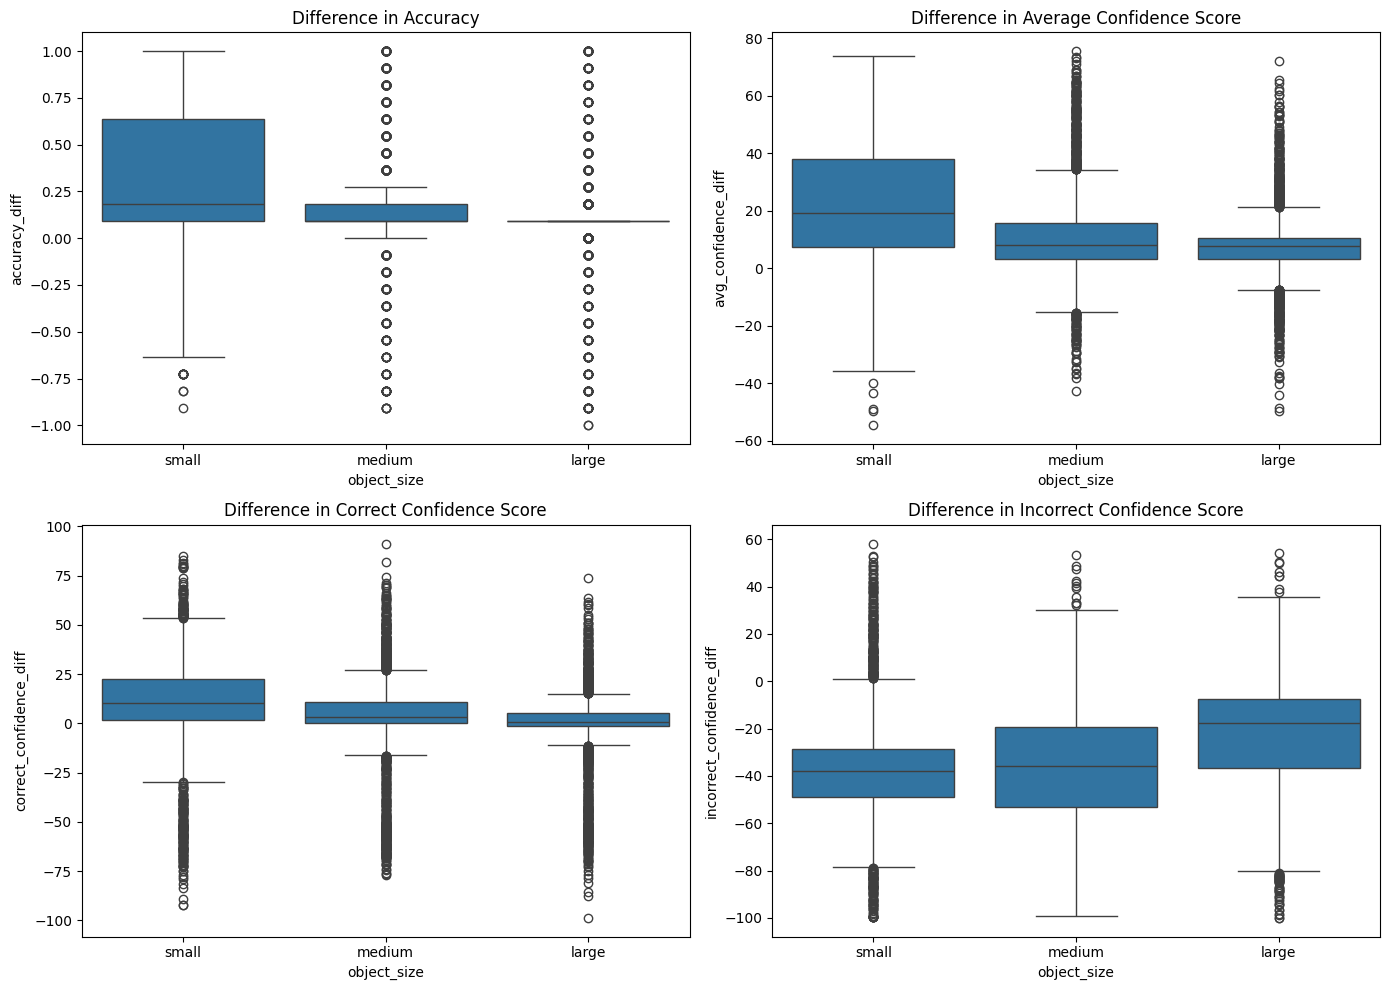

In [144]:
differences_df = calculate_differences_per_image(resnet_df, 'true_label', 'original_prediction', 'object_percentage_category')

plot_differences(differences_df)